[View in Colaboratory](https://colab.research.google.com/github/opooladz/ESPRIT-Autoencoder-Anomaly-Detection/blob/master/QAM_BPSK_AutoEncoder_&_ROC_Curves_ESPRIT.ipynb)

In [0]:
!pip3 install numba

    100% |████████████████████████████████| 1.9MB 2.4MB/s 
    100% |████████████████████████████████| 15.9MB 927kB/s 


In [0]:
import numpy as np
from scipy.linalg import toeplitz
from numpy import linalg as lg
from time import time
from typing import Tuple
import pandas as pd
import pickle
import matplotlib.pyplot as plt
from scipy import stats
import tensorflow as tf
import seaborn as sns
from pylab import rcParams
from sklearn.model_selection import train_test_split
from keras.models import Model, load_model
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers
from numba import jit

flatten = lambda l: [item for sublist in l for item in sublist]

@jit
def compute_autocovariance(x: np.ndarray, M: int) -> np.ndarray:
    """
    This function compute the auto-covariance matrix of a numpy signal.
    The auto-covariance is computed as follows
    .. math:: \textbf{R}=\frac{1}{N}\sum_{M-1}^{N-1}\textbf{x}_{m}\textbf{x}_{m}^{H}
    where :math:`\textbf{x}_{m}^{T}=[x[m],x[m-1],x[m-M+1]]`.
    :param x: 1-D vector of size N
    :param M:  int, optional. Size of signal block.
    :returns: NxN ndarray
    """

    # Create covariance matrix for psd estimation
    # length of the vector x
    x = np.asarray(x).squeeze()
    assert x.ndim == 1, '1-D only'
    N = x.size

    # Create column vector (Nx1) from row array
    x_vect = x[None, :].T

    # init covariance matrix
    yn = x_vect[M-1::-1]  # reverse order from M-1 to 0

    R = yn @ yn.conj().T  # zeroth lag
    # about 5-8% of computation time
    for i in range(1, N-M):  # no zero because we just computed it
        # extract the column vector
        yn = x_vect[M-1+i:i-1:-1]

        R = R + yn @ yn.conj().T

    return R / N


@jit
def wrapper(x):
  return np.convolve(x,xc,mode="valid")

@jit
def esprit1(x: np.ndarray, L: int, M: int=None, fs: int=1,
           verbose: bool=False) -> Tuple[np.ndarray, np.ndarray]:
    """
    This function estimate the frequency components based on the ESPRIT algorithm [ROY89]_
    The frequencies are related to the roots as :math:`z=e^{-2j\pi f/Fe}`.
    See [STO97]_ section 4.7 for more information about the implementation.
    :param x: ndarray, Nsamples
    :param L: int. Number of components to be extracted.
    :param M:  int, optional. Size of signal block.
    :param Fs: float. Sampling Frequency.
    :returns: ndarray ndarray containing the L frequencies
    >>> import numpy as np
    >>> import spectral_analysis.spectral_analysis as sa
    >>> Fe=500
    >>> t=1.*np.arange(100)/Fe
    >>> x=np.exp(2j*np.pi*55.2*t)
    >>> f=sa.Esprit(x,1,None,Fe)
    >>> print(f)
    """

    x = np.asarray(x).squeeze()
    assert x.ndim in (1, 2)
    # length of the vector x
    if x.ndim == 1:
        N = x.size
    else:
        N = x.shape[1]

    if M is None:
        M = N // 2
# %% extract signal subspace  99.9 % of computation time
    #tic = time()
    if x.ndim == 1 and isinstance(M, int):
        R = compute_autocovariance(x, M)  # 75% of computation time        
    else:
        # the random phase of transmit/receive/target actually helps--need at least 5-6 observations to make useful
        R = np.cov(x, rowvar=False)
#     if verbose:
#         print('autocov sec.', time()-tic)
    # R = subspace.corrmtx(x.astype(complex128),M).astype(float) #f2py fortran

    #tic = time()
    #U, S, V = lg.svd(R)  # 25% of computation time
    w, v = lg.eig(R)    
    idx = w.argsort()[::-1]   
    w = w[idx]
    v = v[:,idx]    
#     if verbose:
#         print('svd sec.', time()-tic)
# %% take eigenvalues and determine sinusoid frequencies
    # Remove last row
    S1 = v[:-1, :L]
    # Remove first row
    S2 = v[1:, :L]

    # Compute matrix Phi (Stoica 4.7.12)  <0.1 % of computation time
    Phi = lg.inv(S1.conj().T @ S1) @ S1.conj().T @ S2

    # Perform eigenvalue decomposition <0.1 % of computation time
    V, U = lg.eig(Phi)

    # extract frequencies ((note that there a minus sign since Yn are defined as [y(n), y(n-1),y(n-2),..].T))
    ang = -np.angle(V)

    # frequency normalisation
    f = fs*ang / (2.*np.pi)
    t = np.arange(0, 0.01, 1/fs)
    
    x2 = np.exp(-1j*2*np.pi*t[::-1])[:,np.newaxis]**f
    #display(xc.shape)
    #ampCisoid = np.apply_along_axis(lambda q: np.convolve(q,xc,mode="valid"),axis = 0,arr=x2)
    ampCisoid = np.apply_along_axis(wrapper,axis = 0,arr=x2)
    return f, np.abs(w[:L]), np.abs(ampCisoid)*1./480., np.angle(ampCisoid)
  

def esprit2(x: np.ndarray, L: int, M: int=None, fs: int=1,
           verbose: bool=False) -> Tuple[np.ndarray, np.ndarray]:
    """
    This function estimate the frequency components based on the ESPRIT algorithm [ROY89]_
    The frequencies are related to the roots as :math:`z=e^{-2j\pi f/Fe}`.
    See [STO97]_ section 4.7 for more information about the implementation.
    :param x: ndarray, Nsamples
    :param L: int. Number of components to be extracted.
    :param M:  int, optional. Size of signal block.
    :param Fs: float. Sampling Frequency.
    :returns: ndarray ndarray containing the L frequencies
    >>> import numpy as np
    >>> import spectral_analysis.spectral_analysis as sa
    >>> Fe=500
    >>> t=1.*np.arange(100)/Fe
    >>> x=np.exp(2j*np.pi*55.2*t)
    >>> f=sa.Esprit(x,1,None,Fe)
    >>> print(f)
    """

    x = np.asarray(x).squeeze()
    assert x.ndim in (1, 2)
    # length of the vector x
    if x.ndim == 1:
        N = x.size
    else:
        N = x.shape[1]

    if M is None:
        M = N // 2
# %% extract signal subspace  99.9 % of computation time
    #tic = time()
    if x.ndim == 1 and isinstance(M, int):
        R = compute_autocovariance(x, M)  # 75% of computation time
    else:
        # the random phase of transmit/receive/target actually helps--need at least 5-6 observations to make useful
        R = np.cov(x, rowvar=False)
    #if verbose:
    #    print('autocov sec.', time()-tic)
    # R = subspace.corrmtx(x.astype(complex128),M).astype(float) #f2py fortran

   #tic = time()
    U, S, V = lg.svd(R)  # 25% of computation time
    #w, v = lg.eig(R)    
    #idx = w.argsort()[::-1]   
    #w = w[idx]
    #v = v[:,idx]    
    #if verbose:
    #    print('svd sec.', time()-tic)
# %% take eigenvalues and determine sinusoid frequencies
    # Remove last row
    S1 = U[:-1, :L]
    # Remove first row
    S2 = U[1:, :L]

    # Compute matrix Phi (Stoica 4.7.12)  <0.1 % of computation time
    Phi = lg.inv(S1.conj().T @ S1) @ S1.conj().T @ S2

    # Perform eigenvalue decomposition <0.1 % of computation time
    V, U = lg.eig(Phi)

    # extract frequencies ((note that there a minus sign since Yn are defined as [y(n), y(n-1),y(n-2),..].T))
    ang = -np.angle(V)

    # frequency normalisation
    f = fs*ang / (2.*np.pi)

    return f, S[:L]
  
def removeOutliers(x, outlierConstant):
    a = np.array(x)
    upper_quartile = np.percentile(a, 75)
    lower_quartile = np.percentile(a, 25)
    IQR = (upper_quartile - lower_quartile) * outlierConstant
    quartileSet = (lower_quartile - IQR, upper_quartile + IQR)
    resultList = []
    for y in a.tolist():
        if y >= quartileSet[0] and y <= quartileSet[1]:
            resultList.append(y)
    return resultList
      

In [0]:
# Comms Stuff Will add more later
import math

def qammod(m,y):
  if(np.all(y>=m)):
    print('qammod: all elements of X must be in range [0,M-1]')
  
  if (~np.all(y == np.fix(y) ) ):
    print("qammod: all elements of X must be integers");
  
  c = np.sqrt(m);
  if( ~(np.all(c == np.fix(c)) and np.all(np.math.log(c, 2) == np.fix(np.math.log(c, 2))) ) ):
    print("qammod: M must be a square of a power of 2");
  
  b = -2*np.fmod(y,c) + c - 1.;
  a = 2*np.floor(y *1./c) - c + 1.;
  x = a + 1.*1j*b
  # lets hold x in a np array([real,imag])
  # x = np.array([a,1.*b]).T
  return [x , y] 

def qammod2(m,size,trials):
  """
  m - highest integer for the randint
  """
  y = np.random.randint(m,size=(trials,size))
  if(np.all(y>=m)):
    print('qammod: all elements of X must be in range [0,M-1]')
  
  if (~np.all(y == np.fix(y) ) ):
    print("qammod: all elements of X must be integers");
  
  c = np.sqrt(m);
  if( ~(np.all(c == np.fix(c)) and np.all(np.math.log(c, 2) == np.fix(np.math.log(c, 2))) ) ):
    print("qammod: M must be a square of a power of 2");
  
  b = -2*np.fmod(y,c) + c - 1.;
  a = 2*np.floor(y *1./c) - c + 1.;
  #x = a + 1.*1j*b
  # lets hold x in a dp array([real,imag])
  #x = np.array([a,1.*b])
  x = np.dstack((a,b))
  return [x , y]                        

def sim_channel(m,sequenceLen,trials,Noise,SNRdB,h):
  """
  Simulates a channel
  Input:
    m - order of modulation
    sequenceLen - lenght of sequence
    trials - number trials
    Noise - Boolean, if noise should be added
    SNRdB - Ratio of signal to noise
    h- channel parameters
  """
  [x,y] = qammod2(m,sequenceLen,trials)
  
  xh = np.apply_along_axis(lambda q: np.convolve(q,h,mode="full"),axis = 1,arr=x)
  display(len(xh))
  ## this added for phase offset 7/3/18
  # Phase Offset 
  Ts = 1/(4e6);
  fc1 = 2e6;
  fc2 = 3e6
  fc3 = 4e6
  CP1 = np.exp(np.arange(0,len(xh))*2*1j*math.pi*Ts*fc1)
  #CP2 = np.exp(np.arange(0,len(xh))*2*1j*math.pi*Ts*fc2)
  #CP3 = np.exp(np.arange(0,len(xh))*2*1j*math.pi*Ts*fc3)
  #CP = (CP1 + CP2 + CP3)
  CP = CP1
  CP = CP[:,np.newaxis]
  CP = np.transpose(CP,(1,0))
  xh = np.transpose(xh,(2,1,0))
  display(xh.shape)
  display(CP.shape)
  xh =  xh*CP
  xh = np.transpose(xh,(2,1,0))
  display(xh.shape)  
  ## edit ends 
  
  if(Noise):
    SNR = 10**(SNRdB/10)
    sym_noise_pow = np.var(xh)/SNR
    sym_noise_scale_fact = np.sqrt(sym_noise_pow/2)
    AWGN = sym_noise_scale_fact*np.random.normal(1, size=xh.shape) 
    xh = xh + AWGN
  return [xh ,y ]
  
  
def generateData(m,sequenceLen,trials,Noise,SNRdB,h,padding= True):
  """
  Generates training, testing, and validation data for time invariant channels
  Does one-hot encoding and padding
  m - symbol alphabet
  sequenceLen - length of data sequence
  trials - number of samples
  Noise- Boolean of whether to use AWGN
  SNRdB - amount of noise
  h - channel parameters
  """
  data={}
  [data['x_train'],data['y_train']] = sim_channel(m=m,sequenceLen=sequenceLen,trials=trials,Noise=Noise,SNRdB=SNRdB,h=h)
  [data['x_val'],data['y_val']] = sim_channel(m=m,sequenceLen=sequenceLen,trials=int(trials*0.25),Noise= Noise,SNRdB=SNRdB,h=h)
  [data['x_test'],data['y_test']] = sim_channel(m=m,sequenceLen=sequenceLen,trials=trials,Noise=Noise,SNRdB=SNRdB,h=h)
  
  print("x_train shape: ",data['x_train'].shape) # data, expected seqlen+chanelLen-1
  print("y_train shape: ",data['y_train'].shape) # labels
  
  #One hot encoding
  y_train = keras.utils.to_categorical(data['y_train'] , num_classes=m)
  y_val = keras.utils.to_categorical(data['y_val'] , num_classes=m)
  y_test = keras.utils.to_categorical(data['y_test'] , num_classes=m)
  print("y_train shape, one-hot: ",y_train.shape)

  #Padding 
  if(padding):
    y_train = np.pad(y_train,((0,0),(0,chanelLen-1),(0,0)),"constant")
    y_val = np.pad(y_val,((0,0),(0,chanelLen-1),(0,0)),"constant")
    y_test = np.pad(y_test,((0,0),(0,chanelLen-1),(0,0)),"constant")

  print("y_train shape, one-hot, padding: ",y_train.shape)

  default_data = {
    'x_train': data['x_train'],
    'x_val': data['x_val'],
    'x_test': data['x_test'],
    'y_train': y_train,
    'y_val': y_val,
    'y_test': y_test,
  }
  return default_data
  
  
  
  
def generateData2(m,sequenceLen,trials,Noise,SNRdB,h,padding= True):
  """
  Generates training, testing, and validation data for time invariant channels
  Does one-hot encoding and padding
  m - symbol alphabet
  sequenceLen - length of data sequence
  trials - number of samples
  Noise- Boolean of whether to use AWGN
  SNRdB - amount of noise
  h - channel parameters
  """
  data={}
  [data['x_train'],data['y_train']] = sim_channel(m=m,sequenceLen=sequenceLen,trials=trials,Noise=Noise,SNRdB=SNRdB,h=h)
#  [data['x_val'],data['y_val']] = sim_channel(m=m,sequenceLen=sequenceLen,trials=int(trials*0.25),Noise= Noise,SNRdB=SNRdB,h=h)
  [data['x_test'],data['y_test']] = sim_channel(m=m,sequenceLen=sequenceLen,trials=trials,Noise=Noise,SNRdB=SNRdB,h=h)
  
  print("x_train shape: ",data['x_train'].shape) # data, expected seqlen+chanelLen-1
  print("y_train shape: ",data['y_train'].shape) # labels
  
  default_data = {
    'x_train': data['x_train'],
#    'x_val': data['x_val'],
    'x_test': data['x_test'],
  }
  return default_data
    

In [0]:
"""
Digital Communications Function Module

Mark Wickert November 2013 - September 2014

Development continues!
"""

"""
This program is free software: you can redistribute it and/or modify
it under the terms of the GNU General Public License as published by
the Free Software Foundation, either version 3 of the License, or
(at your option) any later version.

This program is distributed in the hope that it will be useful,
but WITHOUT ANY WARRANTY; without even the implied warranty of
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
GNU General Public License for more details.

You should have received a copy of the GNU General Public License
along with this program.  If not, see <http://www.gnu.org/licenses/>.
"""

from matplotlib import pylab
from matplotlib import mlab
import numpy as np
from numpy import fft
import matplotlib.pyplot as plt
from scipy import signal
from scipy.special import erfc
from sys import exit

def farrow_resample(x, fs_old, fs_new):
    """
    ==========================================================================
     farrow_resample
    ==========================================================================
    y = farrow_resample(x,fs_old, fs_new)
    
    An cubic interpolator using a Farrow structure is used resample the
    input data at a new sampling rate that may be an irrational multiple of
    the input sampling rate.
    
     x = Input signal vector needing resampling
     y = Output signal vector
    
    The filter coefficients used here and a more comprehensive listing can be 
    found in H. Meyr, M. Moeneclaey, & S. Fechtel, "Digital Communication 
    Receivers," Wiley, 1998, Chapter 9, pp. 521-523.
    
    Another good paper on variable interpolators is: L. Erup, F. Gardner, &
    R. Harris, "Interpolation in Digital Modems--Part II: Implementation
    and Performance," IEEE Comm. Trans., June 1993, pp. 998-1008.
    
    A founding paper on the subject of interpolators is: C. W. Farrow, "A
    Continuously variable Digital Delay Element," Proceedings of the IEEE
    Intern. Symp. on Circuits Syst., pp. 2641-2645, June 1988.
    
    Mark Wickert April 2003, recoded to Python November 2013
    """
    
    #Cubic interpolator over 4 samples.
    #The base point receives a two sample delay.
    v3 = signal.lfilter([1/6., -1/2., 1/2., -1/6.],1,x)
    v2 = signal.lfilter([0, 1/2., -1, 1/2.],1,x)
    v1 = signal.lfilter([-1/6., 1, -1/2., -1/3.],1,x)
    v0 = signal.lfilter([0, 0, 1],1,x)
    
    Ts_old = 1/float(fs_old)
    Ts_new = 1/float(fs_new)
    
    T_end = Ts_old*(len(x)-3)
    t_old = np.arange(0,T_end+Ts_old,Ts_old)
    t_new = np.arange(0,T_end+Ts_old,Ts_new)
    if x.dtype == np.dtype('complex128') or x.dtype == np.dtype('complex64'):
        y = np.zeros(len(t_new)) + 1j*np.zeros(len(t_new))
    else:
        y = np.zeros(len(t_new))

    for n in xrange(len(t_new)):
        n_old = np.floor(n*Ts_new/Ts_old)
        mu = (n*Ts_new - n_old*Ts_old)/Ts_old;
        #Combine outputs
        #y(n) = ((v3(n_old+2)*mu + v2(n_old+2))*mu + v1(n_old+2))*mu + v0(n_old+2);
        y[n] = ((v3[n_old+1]*mu + v2[n_old+1])*mu 
                + v1[n_old+1])*mu + v0[n_old+1]
    return y

def upsample(x,L):
    """
    Upsample by factor L
    
    Insert L - 1 zero samples in between each input sample.
    
    Parameters
    ----------
    x : ndarray of input signal values
    L : upsample factor
    
    Returns
    -------
    y : ndarray of the output signal values
    
    Examples
    --------
    >>> y = upsample(x,3)
    """
    N_input = len(x)
    y = np.hstack((x.reshape(N_input,1),np.zeros((N_input,L-1))))
    y = y.flatten()
    return y
    
def downsample(x,M,p=0):
    """
    Downsample by factor M

    Keep every Mth sample of the input. The phase of the input samples
    kept can be selected.

    Parameters
    ----------
    x : ndarray of input signal values
    M : upsample factor
    p : phase of decimated value, 0 (default), 1, ..., M-1

    Returns
    -------
    y : ndarray of the output signal values

    Examples
    --------
    >>> y = downsample(x,3)
    >>> y = downsample(x,3,1)
    """
    x = x[0:np.floor(len(x)/M)*M]
    x = x.reshape((len(x)/M,M))
    y = x[:,p]
    return y
    
def eye_plot(x,L,S=0):
    """
    Eye pattern plot of a baseband digital communications waveform.

    The signal must be real, but can be multivalued in terms of the underlying
    modulation scheme. Used for BPSK eye plots in the Case Study article.

    Parameters
    ----------
    x : ndarray of the real input data vector/array
    L : display length in samples (usually two symbols)
    S : start index

    Returns
    -------
    Nothing : A plot window opens containing the eye plot
    
    Notes
    -----
    Increase S to eliminate filter transients.
    
    Examples
    --------
    >>> # 1000 bits at 10 samples per bit with 'rc' shaping
    >>> x,b, data = NRZ_bits(1000,10,'rc')
    >>> eye_plot(x,20,60)
    """
    plt.figure(figsize=(6,4))
    idx = np.arange(0,L+1)
    plt.plot(idx,x[S:S+L+1],'b')
    k_max = int((len(x) - S)/L)-1
    for k in range(1,k_max):
         plt.plot(idx,x[S+k*L:S+L+1+k*L],'b')
    plt.grid()
    plt.xlabel('Time Index - n')
    plt.ylabel('Amplitude')
    plt.title('Eye Plot')
    return 0

def scatter(x,Ns,start):
    """
    Sample a baseband digital communications waveform at the symbol spacing.

    Parameters
    ----------
    x : ndarray of the input digital comm signal
    Ns : number of samples per symbol (bit)
    start : the array index to start the sampling

    Returns
    -------
    xI : ndarray of the real part of x following sampling
    xQ : ndarray of the imaginary part of x following sampling

    Notes
    -----
    Normally the signal is complex, so the scatter plot contains 
    clusters at point  in the complex plane. For a binary signal 
    such as BPSK, the point centers are nominally +/-1 on the real
    axis. Start is used to eliminate transients from the FIR
    pulse shaping filters from appearing in the scatter plot.

    Examples
    --------
    >>> x,b, data = NRZ_bits(1000,10,'rc')
    >>> # add some noise so points are now scattered about +/-1
    >>>  y = cpx_AWGN(x,20,10)
    >>>  yI,yQ = scatter(y,10,60)
    >>> plot(yI,yQ,'.')
    >>> axis('equal')
    """
    xI = np.real(x[start::Ns])
    xQ = np.imag(x[start::Ns])
    return xI, xQ

def strips(x,Nx,fig_size=(6,4)):
    """
    Plots the contents of real ndarray x as a vertical stacking of
    strips, each of length Nx. The default figure size is (6,4) inches.
    The yaxis tick labels are the starting index of each strip. The red
    dashed lines correspond to zero amplitude in each strip.

    strips(x,Nx,my_figsize=(6,4))

    Mark Wickert April 2014
    """
    plt.figure(figsize=fig_size)
    #ax = fig.add_subplot(111)
    N = len(x)
    Mx = int(np.ceil(N/float(Nx)))
    x_max = np.max(np.abs(x))
    for kk in range(Mx):
        plt.plot(np.array([0,Nx]),-kk*Nx*np.array([1,1]),'r-.')
        plt.plot(x[kk*Nx:(kk+1)*Nx]/x_max*0.4*Nx-kk*Nx,'b')
    plt.axis([0,Nx,-Nx*(Mx-0.5),Nx*0.5])
    plt.yticks(np.arange(0,-Nx*Mx,-Nx),np.arange(0,Nx*Mx,Nx))
    plt.xlabel('Index')
    plt.ylabel('Strip Amplitude and Starting Index')
    return 0

def bit_errors(tx_data,rx_data,Ncorr = 1024,Ntransient = 0):
    """
    Count bit errors between a transmitted and received BPSK signal.
    Time delay between streams is detected as well as ambiquity resolution
    due to carrier phase lock offsets of k*pi, k=0,1.
    The ndarray tx_data is Tx 0/1 bits as real numbers I.
    The ndarray rx_data is Rx 0/1 bits as real numbers I.
    Note: Ncorr needs to be even
    """
    
    #Remove Ntransient symbols and level shift to {-1,+1}
    tx_data = 2*tx_data[Ntransient:]-1
    rx_data = 2*rx_data[Ntransient:]-1
    #Correlate the first Ncorr symbols at four possible phase rotations
    R0 = np.fft.ifft(np.fft.fft(rx_data,Ncorr)*
                     np.conj(np.fft.fft(tx_data,Ncorr)))
    R1 = np.fft.ifft(np.fft.fft(-1*rx_data,Ncorr)*
                     np.conj(np.fft.fft(tx_data,Ncorr)))
    #Place the zero lag value in the center of the array
    R0 = np.fft.fftshift(R0)
    R1 = np.fft.fftshift(R1)
    R0max = np.max(R0.real)
    R1max = np.max(R1.real)
    R = np.array([R0max,R1max])
    Rmax = np.max(R)
    kphase_max = np.where(R == Rmax)[0]
    kmax = kphase_max[0]
    #Correlation lag value is zero at the center of the array
    if kmax == 0:
        lagmax = np.where(R0.real == Rmax)[0] - Ncorr/2
    elif kmax == 1:
        lagmax = np.where(R1.real == Rmax)[0] - Ncorr/2
    taumax = lagmax[0]
    print('kmax =  %d, taumax = %d' % (kmax, taumax))
    #return R0,R1,R2,R3
    #Count bit and symbol errors over the entire input ndarrays
    #Begin by making tx and rx length equal and apply phase rotation to rx
    if taumax < 0:
        tx_data = tx_data[-taumax:]
        tx_data = tx_data[:min(len(tx_data),len(rx_data))]
        rx_data = (-1)**kmax*rx_data[:len(tx_data)]
    else:
        rx_data = (-1)**kmax*rx_data[taumax:]
        rx_data = rx_data[:min(len(tx_data),len(rx_data))]
        tx_data = tx_data[:len(rx_data)]
    #Convert to 0's and 1's
    Bit_count = len(tx_data)
    tx_I = np.int16((tx_data.real + 1)/2)
    rx_I = np.int16((rx_data.real + 1)/2)
    Bit_errors = tx_I ^ rx_I
    return Bit_count,np.sum(Bit_errors)

def cpx_AWGN(x,EsN0,Ns):
    """
    Apply white Gaussian noise to a digital communications signal.

    This function represents a complex baseband white Gaussian noise
    digital communications channel. The input signal array may be real
    or complex.

    Parameters
    ----------
    x : ndarray noise free complex baseband input signal.
    EsNO : set the channel Es/N0 (Eb/N0 for binary) level in dB
    Ns : number of samples per symbol (bit)

    Returns
    -------
    y : ndarray x with additive noise added.

    Notes
    -----
    Set the channel energy per symbol-to-noise power spectral 
    density ratio (Es/N0) in dB.

    Examples
    --------
    >>> x,b, data = NRZ_bits(1000,10)
    >>> # set Eb/N0 = 10 dB
    >>> y = cpx_AWGN(x,10,10)
    """
    w = np.sqrt(Ns*np.var(x)*10**(-EsN0/10.)/2.)
    w *= (np.random.randn(len(x)) + 1j*np.random.randn(len(x)))                         
    return x+w
    
def CIC(M,K):
    """
    b = CIC(M,K)
    A functional form implementation of a cascade of integrator comb (CIC) 
    filters. Commonly used in multirate signal processing digital
    down-converters and digital up-converters. A true CIC filter requires no
    multiplies, only add and subtract operations. The functional form created
    here is a simple FIR requiring real coefficient multiplies via filter()
    ========================================================================
      M = Effective number of taps per section (typically the decimation
          factor).
      K = The number of CIC sections cascaded (larger K gives the filter a
          wider image rejection bandwidth.
      b = FIR filter coefficients for a simple direct form implementation
          using the filter() function.
    ========================================================================
    Mark Wickert July 2013
    """
    
    if K == 1:
        b = np.ones(M)
    else:
        h = np.ones(M)
        b = h
        for i in range(1,K):
            b = signal.convolve(b,h) # cascade by convolving impulse responses
    
    # Make filter have unity gain at DC
    return b/np.sum(b)

def QAM_bb(N_symb,Ns,mod_type='16qam',pulse='rect',alpha=0.35):
    """
    QAM_BB_TX: A complex baseband transmitter 
    x,b,tx_data = QAM_bb(K,Ns,M)

    //////////// Inputs //////////////////////////////////////////////////
      N_symb = the number of symbols to process
          Ns = number of samples per symbol
    mod_type = modulation type: qpsk, 16qam, 64qam, or 256qam
       alpha = squareroot raised codine pulse shape bandwidth factor.
               For DOCSIS alpha = 0.12 to 0.18. In general alpha can 
               range over 0 < alpha < 1.
         SRC = pulse shape: 0-> rect, 1-> SRC
    //////////// Outputs /////////////////////////////////////////////////
           x = complex baseband digital modulation
           b = transmitter shaping filter, rectangle or SRC
     tx_data = xI+1j*xQ = inphase symbol sequence + 
               1j*quadrature symbol sequence

    Mark Wickert November 2014
    """
    # Filter the impulse train waveform with a square root raised
    # cosine pulse shape designed as follows:

    # Design the filter to be of duration 12 symbols and
    # fix the excess bandwidth factor at alpha = 0.35
    # If SRC = 0 use a simple rectangle pulse shape
    if pulse.lower() == 'src':
        b = sqrt_rc_imp(Ns,alpha,6)
    elif pulse.lower() == 'rc':
        b = rc_imp(Ns,alpha,6)    
    elif pulse.lower() == 'rect':
        b = np.ones(Ns) #alt. rect. pulse shape
    else:
        print('pulse shape must be src, rc, or rect')
        
    if mod_type.lower() == 'qpsk':
        M = 2 # bits per symbol
    elif mod_type.lower() == '16qam':
        M = 4
    elif mod_type.lower() == '64qam':
        M = 8
    elif mod_type.lower() == '256qam':
        M = 16
    else:
        print('Unknown mod_type')

    # Create random symbols for the I & Q channels
    xI = np.random.randint(0,M,N_symb)
    xI = 2*xI - (M-1)
    xQ = np.random.randint(0,M,N_symb)
    xQ = 2*xQ - (M-1)
    # Employ differential encoding to counter phase ambiquities
    #y = mod(lfilter(1,[1 -1],yi),M);

    # Create a zero padded (interpolated by Ns) symbol sequence.
    # This prepares the symbol sequence for arbitrary pulse shaping.
    symbI = np.hstack((xI.reshape(N_symb,1),np.zeros((N_symb,Ns-1))))
    symbI = symbI.flatten()
    symbQ = np.hstack((xQ.reshape(N_symb,1),np.zeros((N_symb,Ns-1))))
    symbQ = symbQ.flatten()
    symb = symbI + 1j*symbQ
    if M > 2:
        symb /= (M-1)
    
    #The impulse train waveform contains one pulse per Ns (or Ts) samples
    #imp_train = [ones(K,1) zeros(K,Ns-1)]';
    #imp_train = reshape(imp_train,Ns*K,1);

    # Filter the impulse train signal
    x = signal.lfilter(b,1,symb)
    x = x.flatten() # out is a 1D vector
    # Scale shaping filter to have unity DC gain
    b = b/sum(b)
    return x, b, xI+1j*xQ

def QAM_SEP(tx_data,rx_data,mod_type,Ncorr = 1024,Ntransient = 0,SEP_disp=True):
    """
    Nsymb, Nerr, SEP_hat =
    QAM_symb_errors(tx_data,rx_data,mod_type,Ncorr = 1024,Ntransient = 0)
    
    Count symbol errors between a transmitted and received QAM signal.
    The received symbols are assumed to be soft values on a unit square.
    Time delay between streams is detected.
    The ndarray tx_data is Tx complex symbols.
    The ndarray rx_data is Rx complex symbols.
    Note: Ncorr needs to be even
    """
    #Remove Ntransient symbols and makes lengths equal
    tx_data = tx_data[Ntransient:]
    rx_data = rx_data[Ntransient:]
    Nmin = min([len(tx_data),len(rx_data)])
    tx_data = tx_data[:Nmin]
    rx_data = rx_data[:Nmin]
    
    # Perform level translation and quantize the soft symbol values
    if mod_type.lower() == 'qpsk':
        M = 2 # bits per symbol
    elif mod_type.lower() == '16qam':
        M = 4
    elif mod_type.lower() == '64qam':
        M = 8
    elif mod_type.lower() == '256qam':
        M = 16
    else:
        print('Unknown mod_type')
    rx_data = np.rint((M-1)*(rx_data + (1+1j))/2.)
    # Fix-up edge points real part
    s1r = mlab.find(rx_data.real > M - 1)
    s2r = mlab.find(rx_data.real < 0)
    rx_data.real[s1r] = (M - 1)*np.ones(len(s1r))
    rx_data.real[s2r] = np.zeros(len(s2r))
    # Fix-up edge points imag part
    s1i = mlab.find(rx_data.imag > M - 1)
    s2i = mlab.find(rx_data.imag < 0)
    rx_data.imag[s1i] = (M - 1)*np.ones(len(s1i))
    rx_data.imag[s2i] = np.zeros(len(s2i))
    #plot(rx_data.real,rx_data.imag,'.')
    rx_data = 2*rx_data - (M - 1)*(1 + 1j)
    #plot(rx_data.real,rx_data.imag,'.')
    #plot(tx_data.real,tx_data.imag,'.')
    #axis('equal')
    #grid();
    #Correlate the first Ncorr symbols at four possible phase rotations
    R0,lags = xcorr(rx_data,tx_data,Ncorr)
    R1,lags = xcorr(rx_data*(1j)**1,tx_data,Ncorr) 
    R2,lags = xcorr(rx_data*(1j)**2,tx_data,Ncorr) 
    R3,lags = xcorr(rx_data*(1j)**3,tx_data,Ncorr) 
    #Place the zero lag value in the center of the array
    R0max = np.max(R0.real)
    R1max = np.max(R1.real)
    R2max = np.max(R2.real)
    R3max = np.max(R3.real)
    R = np.array([R0max,R1max,R2max,R3max])
    Rmax = np.max(R)
    kphase_max = np.where(R == Rmax)[0]
    kmax = kphase_max[0]
    #Find correlation lag value is zero at the center of the array
    if kmax == 0:
        lagmax = lags[np.where(R0.real == Rmax)[0]]
    elif kmax == 1:
        lagmax = lags[np.where(R1.real == Rmax)[0]]
    elif kmax == 2:
        lagmax = lags[np.where(R2.real == Rmax)[0]]
    elif kmax == 3:
        lagmax = lags[np.where(R3.real == Rmax)[0]]
    taumax = lagmax[0]
    if SEP_disp:
        print('Phase ambiquity = (1j)**%d, taumax = %d' % (kmax, taumax))
    #Count symbol errors over the entire input ndarrays
    #Begin by making tx and rx length equal and apply 
    #phase rotation to rx_data
    if taumax < 0:
        tx_data = tx_data[-taumax:]
        tx_data = tx_data[:min(len(tx_data),len(rx_data))]
        rx_data = (1j)**kmax*rx_data[:len(tx_data)]
    else:
        rx_data = (1j)**kmax*rx_data[taumax:]
        rx_data = rx_data[:min(len(tx_data),len(rx_data))]
        tx_data = tx_data[:len(rx_data)]
    #Convert QAM symbol difference to symbol errors
    errors = np.int16(abs(rx_data-tx_data))
    # Detect symbols errors
    # Could decode bit errors from symbol index difference
    idx = mlab.find(errors != 0)
    if SEP_disp:
        print('Symbols = %d, Errors %d, SEP = %1.2e' \
               % (len(errors), len(idx), len(idx)/float(len(errors))))
    return  len(errors), len(idx), len(idx)/float(len(errors))

def GMSK_bb(N_bits, Ns, MSK = 0,BT = 0.35):
    """
    MSK/GMSK COoplex Beband Modulation
    x,data = gmsk(N_bits, Ns, BT = 0.35, MSK = 0)
    
    N_bits = number of symbols processed
       Ns  = the number of samples per bit
       MSK = 0 for no shaping which is standard MSK,
             MSK <> 0 --> GMSK is generated.
       BT  = premodulation Bb*T product which sets
             the bandwidth of the Gaussian lowpass filter   
    Mark Wickert Python version November 2014
    """
    x, b, data = NRZ_bits(N_bits,Ns)
    # pulse length 2*M*Ns
    M = 4
    n = np.arange(-M*Ns,M*Ns+1)
    p = np.exp(-2*np.pi**2*BT**2/np.log(2)*(n/Ns)**2);
    p = p/np.sum(p);

    # Gaussian pulse shape if MSK not zero
    if MSK != 0:
        x = signal.lfilter(p,1,x)
    y = np.exp(1j*np.pi/2*np.cumsum(x)/Ns)
    return y, data

def MPSK_bb(N_symb,Ns,M,pulse='rect',alpha = 0.25,MM=6):
    """
    Generate non-return-to-zero (NRZ) data bits with pulse shaping.

    A baseband digital data signal using +/-1 amplitude signal values
    and including pulse shaping.

    Parameters
    ----------
    N_bits : number of NRZ +/-1 data bits to produce
    Ns : the number of samples per bit,
    pulse_type : 'rect' , 'rc', 'src' (default 'rect')
    alpha : excess bandwidth factor(default 0.25)
    M : single sided pulse duration (default = 6) 

    Returns
    -------
    x : ndarray of the NRZ signal values
    b : ndarray of the pulse shape
    data : ndarray of the underlying data bits

    Notes
    -----
    Pulse shapes include 'rect' (rectangular), 'rc' (raised cosine), 
    'src' (root raised cosine). The actual pulse length is 2*M+1 samples.
    This function is used by BPSK_tx in the Case Study article.

    Examples
    --------
    >>> x,b,data = NRZ_bits(100,10)
    >>> t = arange(len(x))
    >>> plot(t,x)
    """
    data = np.random.randint(0,M,N_symb) 
    xs = np.exp(1j*2*np.pi/M*data)
    x = np.hstack((xs.reshape(N_symb,1),np.zeros((N_symb,Ns-1))))
    x =x.flatten()
    if pulse.lower() == 'rect':
        b = np.ones(Ns)
    elif pulse.lower() == 'rc':
        b = rc_imp(Ns,alpha,MM)
    elif pulse.lower() == 'src':
        b = sqrt_rc_imp(Ns,alpha,MM)
    else:
        print ('pulse type must be rec, rc, or src')
    x = signal.lfilter(b,1,x)
    if M == 4:
        x = x*np.exp(1j*np.pi/4); # For QPSK points in quadrants
    return x,b/float(Ns),data

def QPSK_rx(fc,N_symb,Rs,EsN0=100,fs=125,lfsr_len=10,phase=0,pulse='src'):
    """
    This function generates
    """
    Ns = int(np.round(fs/Rs))
    print ('Ns = ', Ns)
    print ('Rs = ', fs/float(Ns))
    print ('EsN0 = ', EsN0, 'dB')
    print ('phase = ', phase, 'degrees')
    print ('pulse = ', pulse)
    x, b, data = QPSK_bb(N_symb,Ns,lfsr_len,pulse)
    # Add AWGN to x
    x = cpx_AWGN(x,EsN0,Ns)
    n = np.arange(len(x))
    xc = x*np.exp(1j*2*np.pi*fc/float(fs)*n) * np.exp(1j*phase)
    return xc, b, data

def QPSK_tx(fc,N_symb,Rs,fs=125,lfsr_len=10,pulse='src'):
    """

    """
    Ns = int(np.round(fs/Rs))
    print ('Ns = ', Ns)
    print ('Rs = ', fs/float(Ns))
    print ('pulse = ', pulse)
    x, b, data = QPSK_bb(N_symb,Ns,lfsr_len,pulse)
    n = np.arange(len(x))
    xc = x*np.exp(1j*2*np.pi*fc/float(fs)*n)
    return xc, b, data 

def QPSK_bb(N_symb,Ns,lfsr_len=5,pulse='src',alpha=0.25,M=6):
    """
    
    """
    if lfsr_len > 0:  # LFSR data
        data = PN_gen(2*N_symb,lfsr_len)
        dataI = data[0::2]
        dataQ = data[1::2]
        xI, b = NRZ_bits2(dataI,Ns,pulse,alpha,M)
        xQ, b = NRZ_bits2(dataQ,Ns,pulse,alpha,M)
    else:             # Random data
        data = np.zeros(2*N_symb)
        xI, b, data[0::2] = NRZ_bits(N_symb,Ns,pulse,alpha,M)
        xQ, b, data[1::2] = NRZ_bits(N_symb,Ns,pulse,alpha,M)        
    #print 'P_I: ',np.var(xI), 'P_Q: ',np.var(xQ)
    x = (xI + 1j*xQ)/np.sqrt(2.)
    return x, b, data

def QPSK_BEP(tx_data,rx_data,Ncorr = 1024,Ntransient = 0):
    """
    Count bit errors between a transmitted and received QPSK signal.
    Time delay between streams is detected as well as ambiquity resolution
    due to carrier phase lock offsets of k*pi/4, k=0,1,2,3.
    The ndarray sdata is Tx +/-1 symbols as complex numbers I + j*Q.
    The ndarray data is Rx +/-1 symbols as complex numbers I + j*Q.
    Note: Ncorr needs to be even
    """
    
    #Remove Ntransient symbols
    tx_data = tx_data[Ntransient:]
    rx_data = rx_data[Ntransient:]
    #Correlate the first Ncorr symbols at four possible phase rotations
    R0 = np.fft.ifft(np.fft.fft(rx_data,Ncorr)*
                     np.conj(np.fft.fft(tx_data,Ncorr)))
    R1 = np.fft.ifft(np.fft.fft(1j*rx_data,Ncorr)*
                     np.conj(np.fft.fft(tx_data,Ncorr)))
    R2 = np.fft.ifft(np.fft.fft(-1*rx_data,Ncorr)*
                     np.conj(np.fft.fft(tx_data,Ncorr)))
    R3 = np.fft.ifft(np.fft.fft(-1j*rx_data,Ncorr)*
                     np.conj(np.fft.fft(tx_data,Ncorr)))
    #Place the zero lag value in the center of the array
    R0 = np.fft.fftshift(R0)
    R1 = np.fft.fftshift(R1)
    R2 = np.fft.fftshift(R2)
    R3 = np.fft.fftshift(R3)
    R0max = np.max(R0.real)
    R1max = np.max(R1.real)
    R2max = np.max(R2.real)
    R3max = np.max(R3.real)
    R = np.array([R0max,R1max,R2max,R3max])
    Rmax = np.max(R)
    kphase_max = np.where(R == Rmax)[0]
    kmax = kphase_max[0]
    #Correlation lag value is zero at the center of the array
    if kmax == 0:
        lagmax = np.where(R0.real == Rmax)[0] - Ncorr/2
    elif kmax == 1:
        lagmax = np.where(R1.real == Rmax)[0] - Ncorr/2
    elif kmax == 2: 
        lagmax = np.where(R2.real == Rmax)[0] - Ncorr/2
    elif kmax == 3:
        lagmax = np.where(R3.real == Rmax)[0] - Ncorr/2
    taumax = lagmax[0]
    print('kmax =  %d, taumax = %d' % (kmax, taumax))
    #return R0,R1,R2,R3
    #Count bit and symbol errors over the entire input ndarrays
    #Begin by making tx and rx length equal and apply phase rotation to rx
    if taumax < 0:
        tx_data = tx_data[-taumax:]
        tx_data = tx_data[:min(len(tx_data),len(rx_data))]
        rx_data = 1j**kmax*rx_data[:len(tx_data)]
    else:
        rx_data = 1j**kmax*rx_data[taumax:]
        rx_data = rx_data[:min(len(tx_data),len(rx_data))]
        tx_data = tx_data[:len(rx_data)]
    #Convert to 0's and 1's
    S_count = len(tx_data)
    tx_I = np.int16((tx_data.real + 1)/2)
    tx_Q = np.int16((tx_data.imag + 1)/2)
    rx_I = np.int16((rx_data.real + 1)/2)
    rx_Q = np.int16((rx_data.imag + 1)/2)
    I_errors = tx_I ^ rx_I
    Q_errors = tx_Q ^ rx_Q
    #A symbol errors occurs when I or Q or both are in error
    S_errors = I_errors | Q_errors
    #return 0
    return S_count,np.sum(I_errors),np.sum(Q_errors),np.sum(S_errors)

def BPSK_BEP(tx_data,rx_data,Ncorr = 1024,Ntransient = 0):
    """
    Count bit errors between a transmitted and received BPSK signal.
    Time delay between streams is detected as well as ambiquity resolution
    due to carrier phase lock offsets of k*pi, k=0,1.
    The ndarray tx_data is Tx +/-1 symbols as real numbers I.
    The ndarray rx_data is Rx +/-1 symbols as real numbers I.
    Note: Ncorr needs to be even
    """
    
    #Remove Ntransient symbols
    tx_data = tx_data[Ntransient:]
    rx_data = rx_data[Ntransient:]
    #Correlate the first Ncorr symbols at four possible phase rotations
    R0 = np.fft.ifft(np.fft.fft(rx_data,Ncorr)*
                     np.conj(np.fft.fft(tx_data,Ncorr)))
    R1 = np.fft.ifft(np.fft.fft(-1*rx_data,Ncorr)*
                     np.conj(np.fft.fft(tx_data,Ncorr)))
    #Place the zero lag value in the center of the array
    R0 = np.fft.fftshift(R0)
    R1 = np.fft.fftshift(R1)
    R0max = np.max(R0.real)
    R1max = np.max(R1.real)
    R = np.array([R0max,R1max])
    Rmax = np.max(R)
    kphase_max = np.where(R == Rmax)[0]
    kmax = kphase_max[0]
    #Correlation lag value is zero at the center of the array
    if kmax == 0:
        lagmax = np.where(R0.real == Rmax)[0] - Ncorr/2
    elif kmax == 1:
        lagmax = np.where(R1.real == Rmax)[0] - Ncorr/2
    taumax = lagmax[0]
    print('kmax =  %d, taumax = %d' % (kmax, taumax))
    #return R0,R1,R2,R3
    #Count bit and symbol errors over the entire input ndarrays
    #Begin by making tx and rx length equal and apply phase rotation to rx
    if taumax < 0:
        tx_data = tx_data[-taumax:]
        tx_data = tx_data[:min(len(tx_data),len(rx_data))]
        rx_data = (-1)**kmax*rx_data[:len(tx_data)]
    else:
        rx_data = (-1)**kmax*rx_data[taumax:]
        rx_data = rx_data[:min(len(tx_data),len(rx_data))]
        tx_data = tx_data[:len(rx_data)]
    #Convert to 0's and 1's
    S_count = len(tx_data)
    tx_I = np.int16((tx_data.real + 1)/2)
    rx_I = np.int16((rx_data.real + 1)/2)
    I_errors = tx_I ^ rx_I
    #Symbol errors and bit errors are equivalent
    S_errors = I_errors
    #return tx_data, rx_data
    return S_count,np.sum(S_errors)
        
def BPSK_tx(N_bits,Ns,ach_fc=2.0,ach_lvl_dB=-100,pulse='rect',alpha = 0.25,M=6):
    """
    Generates biphase shift keyed (BPSK) transmitter with adjacent channel interference.

    Generates three BPSK signals with rectangular or square root raised cosine (SRC) 
    pulse shaping of duration N_bits and Ns samples per bit. The desired signal is
    centered on f = 0, which the adjacent channel signals to the left and right
    are also generated at dB level relative to the desired signal. Used in the 
    digital communications Case Study supplement.

    Parameters
    ----------
    N_bits : the number of bits to simulate
    Ns : the number of samples per bit
    ach_fc : the frequency offset of the adjacent channel signals (default 2.0)
    ach_lvl_dB : the level of the adjacent channel signals in dB (default -100)
    pulse :the pulse shape 'rect' or 'src'
    alpha : square root raised cosine pulse shape factor (default = 0.25)
    M : square root raised cosine pulse truncation factor (default = 6)

    Returns
    -------
    x : ndarray of the composite signal x0 + ach_lvl*(x1p + x1m)
    b : the transmit pulse shape 
    data0 : the data bits used to form the desired signal; used for error checking

    Notes
    -----

    Examples
    --------
    >>> x,b,data0 = BPSK_tx(1000,10,'src')
    """
    x0,b,data0 = NRZ_bits(N_bits,Ns,pulse,alpha,M)
    x1p,b,data1p = NRZ_bits(N_bits,Ns,pulse,alpha,M)
    x1m,b,data1m = NRZ_bits(N_bits,Ns,pulse,alpha,M)
    n = np.arange(len(x0))
    x1p = x1p*np.exp(1j*2*np.pi*ach_fc/float(Ns)*n)
    x1m = x1m*np.exp(-1j*2*np.pi*ach_fc/float(Ns)*n)
    ach_lvl = 10**(ach_lvl_dB/20.)
    return x0 + ach_lvl*(x1p + x1m), b, data0


def rc_imp(Ns,alpha,M=6):
    """
    A truncated raised cosine pulse used in digital communications.

    The pulse shaping factor 0< alpha < 1 is required as well as the 
    truncation factor M which sets the pulse duration to be 2*M*Tsymbol.

    Parameters
    ----------
    Ns : number of samples per symbol
    alpha : excess bandwidth factor on (0, 1), e.g., 0.35
    M : equals RC one-sided symbol truncation factor

    Returns
    -------
    b : ndarray containing the pulse shape

    Notes
    -----
    The pulse shape b is typically used as the FIR filter coefficients
    when forming a pulse shaped digital communications waveform.

    Examples
    --------
    >>> # ten samples per symbol and alpha = 0.35
    >>> b = rc_imp(10,0.35)
    >>> n = arange(-10*6,10*6+1)
    >>> stem(n,b)
    """
    # Design the filter
    n = np.arange(-M*Ns,M*Ns+1)
    b = np.zeros(len(n));
    a = alpha;
    Ns *= 1.0
    for i in range(len(n)):
        if (1 - 4*(a*n[i]/Ns)**2) == 0:
            b[i] = np.pi/4*np.sinc(1/(2.*a))
        else:
            b[i] = np.sinc(n[i]/Ns)*np.cos(np.pi*a*n[i]/Ns)/(1 - 4*(a*n[i]/Ns)**2)
    return b

def sqrt_rc_imp(Ns,alpha,M=6):
    """
    A truncated square root raised cosine pulse used in digital communications.

    The pulse shaping factor 0< alpha < 1 is required as well as the 
    truncation factor M which sets the pulse duration to be 2*M*Tsymbol.
     

    Parameters
    ----------
    Ns : number of samples per symbol
    alpha : excess bandwidth factor on (0, 1), e.g., 0.35
    M : equals RC one-sided symbol truncation factor

    Returns
    -------
    b : ndarray containing the pulse shape

    Notes
    -----
    The pulse shape b is typically used as the FIR filter coefficients
    when forming a pulse shaped digital communications waveform. When 
    square root raised cosine (SRC) pulse is used generate Tx signals and 
    at the receiver used as a matched filter (receiver FIR filter), the 
    received signal is now raised cosine shaped, this having zero 
    intersymbol interference and the optimum removal of additive white 
    noise if present at the receiver input.

    Examples
    --------
    >>> # ten samples per symbol and alpha = 0.35
    >>> b = sqrt_rc_imp(10,0.35)
    >>> n = arange(-10*6,10*6+1)
    >>> stem(n,b)
    """
    # Design the filter
    n = np.arange(-M*Ns,M*Ns+1)
    b = np.zeros(len(n))
    Ns *= 1.0
    a = alpha
    for i in range(len(n)):
       if abs(1 - 16*a**2*(n[i]/Ns)**2) <= np.finfo(np.float).eps/2:
           b[i] = 1/2.*((1+a)*np.sin((1+a)*np.pi/(4.*a))-(1-a)*np.cos((1-a)*np.pi/(4.*a))+(4*a)/np.pi*np.sin((1-a)*np.pi/(4.*a)))
       else:
           b[i] = 4*a/(np.pi*(1 - 16*a**2*(n[i]/Ns)**2))
           b[i] = b[i]*(np.cos((1+a)*np.pi*n[i]/Ns) + np.sinc((1-a)*n[i]/Ns)*(1-a)*np.pi/(4.*a))
    return b    

def RZ_bits(N_bits,Ns,pulse='rect',alpha = 0.25,M=6):
    """
    Generate return-to-zero (RZ) data bits with pulse shaping.

    A baseband digital data signal using +/-1 amplitude signal values
    and including pulse shaping.

    Parameters
    ----------
    N_bits : number of RZ {0,1} data bits to produce
    Ns : the number of samples per bit,
    pulse_type : 'rect' , 'rc', 'src' (default 'rect')
    alpha : excess bandwidth factor(default 0.25)
    M : single sided pulse duration (default = 6) 

    Returns
    -------
    x : ndarray of the RZ signal values
    b : ndarray of the pulse shape
    data : ndarray of the underlying data bits

    Notes
    -----
    Pulse shapes include 'rect' (rectangular), 'rc' (raised cosine), 
    'src' (root raised cosine). The actual pulse length is 2*M+1 samples.
    This function is used by BPSK_tx in the Case Study article.

    Examples
    --------
    >>> x,b,data = RZ_bits(100,10)
    >>> t = arange(len(x))
    >>> plot(t,x)
    """
    data = np.random.randint(0,2,N_bits) 
    x = np.hstack((data.reshape(N_bits,1),np.zeros((N_bits,Ns-1))))
    x =x.flatten()
    if pulse.lower() == 'rect':
        b = np.ones(Ns)
    elif pulse.lower() == 'rc':
        b = rc_imp(Ns,alpha,M)
    elif pulse.lower() == 'src':
        b = sqrt_rc_imp(Ns,alpha,M)
    else:
        print ('pulse type must be rec, rc, or src')
    x = signal.lfilter(b,1,x)
    return x,b/float(Ns),data

def NRZ_bits(N_bits,Ns,pulse='rect',alpha = 0.25,M=6):
    """
    Generate non-return-to-zero (NRZ) data bits with pulse shaping.

    A baseband digital data signal using +/-1 amplitude signal values
    and including pulse shaping.

    Parameters
    ----------
    N_bits : number of NRZ +/-1 data bits to produce
    Ns : the number of samples per bit,
    pulse_type : 'rect' , 'rc', 'src' (default 'rect')
    alpha : excess bandwidth factor(default 0.25)
    M : single sided pulse duration (default = 6) 

    Returnsbp
    -------
    x : ndarray of the NRZ signal values
    b : ndarray of the pulse shape
    data : ndarray of the underlying data bits

    Notes
    -----
    Pulse shapes include 'rect' (rectangular), 'rc' (raised cosine), 
    'src' (root raised cosine). The actual pulse length is 2*M+1 samples.
    This function is used by BPSK_tx in the Case Study article.

    Examples
    --------
    >>> x,b,data = NRZ_bits(100,10)
    >>> t = arange(len(x))
    >>> plot(t,x)
    """
    data = np.random.randint(0,2,N_bits) 
    x = np.hstack((2*data.reshape(N_bits,1)-1,np.zeros((N_bits,Ns-1))))
    x =x.flatten()
    if pulse.lower() == 'rect':
        b = np.ones(Ns)
    elif pulse.lower() == 'rc':
        b = rc_imp(Ns,alpha,M)
    elif pulse.lower() == 'src':
        b = sqrt_rc_imp(Ns,alpha,M)
    else:
        print ('pulse type must be rec, rc, or src')
    x = signal.lfilter(b,1,x)
    return x,b/float(Ns),data

def NRZ_bits2(data,Ns,pulse='rect',alpha = 0.25,M=6):
    """
    Generate non-return-to-zero (NRZ) data bits with pulse shaping with user data

    A baseband digital data signal using +/-1 amplitude signal values
    and including pulse shaping. The data sequence is user supplied.

    Parameters
    ----------
    data : ndarray of the data bits as 0/1 values
    Ns : the number of samples per bit,
    pulse_type : 'rect' , 'rc', 'src' (default 'rect')
    alpha : excess bandwidth factor(default 0.25)
    M : single sided pulse duration (default = 6) 

    Returns
    -------
    x : ndarray of the NRZ signal values
    b : ndarray of the pulse shape

    Notes
    -----
    Pulse shapes include 'rect' (rectangular), 'rc' (raised cosine), 
    'src' (root raised cosine). The actual pulse length is 2*M+1 samples.

    Examples
    --------
    >>> x,b = NRZ_bits2([m_seq(5),10)
    >>> t = arange(len(x))
    >>> plot(t,x)
    """
    N_bits = len(data)
    x = np.hstack((2*data.reshape(N_bits,1)-1,np.zeros((N_bits,Ns-1))))
    x = x.flatten()
    if pulse.lower() == 'rect':
        b = np.ones(Ns)
    elif pulse.lower() == 'rc':
        b = rc_imp(Ns,alpha,M)
    elif pulse.lower() == 'src':
        b = sqrt_rc_imp(Ns,alpha,M)
    else:
        print ('pulse type must be rec, rc, or src')
    x = signal.lfilter(b,1,x)
    return x,b/float(Ns)
    
def PN_gen(N_bits,m=5):
    """
    Maximal length sequence signal generator.

    Generates a sequence 0/1 bits of N_bit duration. The bits themselves
    are obtained from an m-sequence of length m. Available m-sequence
    (PN generators) include m = 2,3,...,12, & 16.
            
    Parameters
    ----------
    N_bits : the number of bits to generate
    m : the number of shift registers. 2,3, .., 12, & 16

    Returns
    -------
    PN : ndarray of the generator output over N_bits

    Notes
    -----
    The sequence is periodic having period 2**m - 1 (2^m - 1).

    Examples
    --------
    >>> # A 15 bit period signal nover 50 bits
    >>> PN = PN_gen(50,4)
    """
    c = m_seq(m)
    Q = len(c)
    max_periods = int(np.ceil(N_bits/float(Q)))
    PN = np.zeros(max_periods*Q)
    for k in range(max_periods):
        PN[k*Q:(k+1)*Q] = c
    PN = np.resize(PN, (1,N_bits))
    return PN.flatten()

def m_seq(m):
    """
    Generate an m-sequence ndarray using an all-ones initialization.

    Available m-sequence (PN generators) include m = 2,3,...,12, & 16.

    Parameters
    ----------
    m : the number of shift registers. 2,3, .., 12, & 16

    Returns
    -------
    c : ndarray of one period of the m-sequence

    Notes
    -----
    The sequence period is 2**m - 1 (2^m - 1).    

    Examples
    --------
    >>> c = m_seq(5)
    """
    # Load shift register with all ones to start
    sr = np.ones(m)
    # M-squence length is:
    Q = 2**m - 1
    c = np.zeros(Q)

    if m == 2:
        taps = np.array([1, 1, 1])
    elif m == 3:
        taps = np.array([1, 0, 1, 1])
    elif m == 4:
        taps = np.array([1, 0, 0, 1, 1])
    elif m == 5:
        taps = np.array([1, 0, 0, 1, 0, 1])
    elif m == 6:
        taps = np.array([1, 0, 0, 0, 0, 1, 1])
    elif m == 7:
        taps = np.array([1, 0, 0, 0, 1, 0, 0, 1])
    elif m == 8:
        taps = np.array([1, 0, 0, 0, 1, 1, 1, 0, 1])
    elif m == 9:
        taps = np.array([1, 0, 0, 0, 0, 1, 0, 0, 0, 1])
    elif m == 10:
        taps = np.array([1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1])
    elif m == 11:
        taps = np.array([1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1])
    elif m == 12:
        taps = np.array([1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1])
    elif m == 16:
        taps = np.array([1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1])
    else:
        print ('Invalid length specified')
    for n in range(Q):
        tap_xor = 0
        c[n] = sr[-1]
        for k in range(1,m):
            if taps[k] == 1:
                tap_xor = np.bitwise_xor(tap_xor,np.bitwise_xor(int(sr[-1]),int(sr[m-1-k])))
        sr[1:] = sr[:-1]
        sr[0] = tap_xor
    return c
    
def my_psd(x,NFFT=2**10,Fs=1):
    """
    A local version of NumPy's PSD function that returns the plot arrays.

    A mlab.psd wrapper function that returns two ndarrays;
    makes no attempt to auto plot anything.

    Parameters
    ----------
    x : ndarray input signal
    NFFT : a power of two, e.g., 2**10 = 1024
    Fs : the sampling rate in Hz

    Returns
    -------
    Px : ndarray of the power spectrum estimate
    f : ndarray of frequency values
    
    Notes
    -----
    This function makes it easier to overlay spectrum plots because
    you have better control over the axis scaling than when using psd()
    in the autoscale mode.
    
    Examples
    --------
    >>> x,b, data = NRZ_bits(10000,10)
    >>> Px,f = my_psd(x,2**10,10)
    >>> plot(f, 10*log10(Px))

    """
    Px,f = pylab.mlab.psd(x,NFFT,Fs)
    return Px.flatten(), f
    
def time_delay(x,D,N=4):
    """
    A time varying time delay which takes advantage of the Farrow structure
    for cubic interpolation:

    y = time_delay(x,D,N = 3)

    Note that D is an array of the same length as the input signal x. This
    allows you to make the delay a function of time. If you want a constant 
    delay just use D*zeros(len(x)). The minimum delay allowable is one sample
    or D = 1.0. This is due to the causal system nature of the Farrow 
    structure.

    A founding paper on the subject of interpolators is: C. W. Farrow, "A
    Continuously variable Digital Delay Element," Proceedings of the IEEE
    Intern. Symp. on Circuits Syst., pp. 2641-2645, June 1988.

    Mark Wickert, February 2014
    """

    if type(D) == float or type(D) == int:
        #Make sure D stays with in the tapped delay line bounds
        if int(np.fix(D)) < 1:
            print('D has integer part less than one')
            exit(1)
        if int(np.fix(D)) > N-2:
            print('D has integer part greater than N - 2')
            exit(1)
        # Filter 4-tap input with four Farrow FIR filters
        # Since the time delay is a constant, the LTI filter
        # function from scipy.signal is convenient.
        D_frac = D - np.fix(D)
        Nd = int(np.fix(D))
        b = np.zeros(Nd + 4)
        # Load Lagrange coefficients into the last four FIR taps
        b[Nd] = -(D_frac-1)*(D_frac-2)*(D_frac-3)/6.
        b[Nd + 1] = D_frac*(D_frac-2)*(D_frac-3)/2.
        b[Nd + 2] = -D_frac*(D_frac-1)*(D_frac-3)/2.
        b[Nd + 3] = D_frac*(D_frac-1)*(D_frac-2)/6.
        # Do all of the filtering in one step for this special case
        # of a fixed delay.
        y = signal.lfilter(b,1,x)
    else:
        #Make sure D stays with in the tapped delay line bounds
        if np.fix(np.min(D)) < 1:
            print('D has integer part less than one')
            exit(1)
        if np.fix(np.max(D)) > N-2:
            print('D has integer part greater than N - 2')
            exit(1)
        y = np.zeros(len(x))
        X = np.zeros(N+1)
        # Farrow filter tap weights
        W3 = np.array([[1./6, -1./2, 1./2, -1./6]])
        W2 = np.array([[0, 1./2, -1., 1./2]])
        W1 = np.array([[-1./6, 1., -1./2, -1./3]])
        W0 = np.array([[0, 0, 1., 0]])
        for k in range(len(x)):
            Nd = int(np.fix(D[k]))
            mu = 1 - (D[k]-np.fix(D[k]))
            # Form a row vector of signal samples, present and past values
            X = np.hstack((np.array(x[k]), X[:-1]))
            # Filter 4-tap input with four Farrow FIR filters
            # Here numpy dot(A,B) performs the matrix multiply
            # since the filter has time-varying coefficients
            v3 = np.dot(W3,np.array(X[Nd-1:Nd+3]).T)
            v2 = np.dot(W2,np.array(X[Nd-1:Nd+3]).T)
            v1 = np.dot(W1,np.array(X[Nd-1:Nd+3]).T)
            v0 = np.dot(W0,np.array(X[Nd-1:Nd+3]).T)
            #Combine sub-filter outputs using mu = 1 - d
            y[k] = ((v3[0]*mu + v2[0])*mu + v1[0])*mu + v0[0]
    return y

def xcorr(x1,x2,Nlags):
    """
    r12, k = xcorr(x1,x2,Nlags), r12 and k are ndarray's
    Compute the energy normalized cross correlation between the sequences
    x1 and x2. If x1 = x2 the cross correlation is the autocorrelation.
    The number of lags sets how many lags to return centered about zero
    """
    K = 2*(len(x1)/2)
    X1 = fft.fft(x1[:K])
    X2 = fft.fft(x2[:K])
    E1 = sum(abs(x1[:K])**2)
    E2 = sum(abs(x2[:K])**2)
    r12 = np.fft.ifft(X1*np.conj(X2))/np.sqrt(E1*E2)
    k = np.arange(K) - K/2
    r12 = np.fft.fftshift(r12)
    idx = mlab.find(abs(k) <= Nlags)
    return r12[idx], k[idx]

def Q_fctn(x):
    """
    Gaussian Q-function
    """
    return 1./2*erfc(x/np.sqrt(2.))

# if __name__ == '__main__':
#     w = np.random.randn(100) + 1j*np.random.randn(100)
#     b = signal.firwin(20,2*.1)
#     wf = signal.lfilter(b,1,w)
    
#     print(wf)
    

In [0]:
from time import time
import numpy as np
from pandas import DataFrame
# Instantiating Comms Data 

m = 4         # order of modulation
trials = 602 # number of trials 
Noise = False
SNRdB = 20
seqLen = 1
print(seqLen)
#h = [1,0.4,0.3,0.2,0.25]
chanelLen = 1
h = np.random.rand(chanelLen)
h[0] = 1
data = generateData2(m,seqLen,trials,Noise,SNRdB,h,padding= True)
commsDataTrain = data['x_train'][:,0,:].dot(np.array([1 ,1j ])).tolist()
commsDataTrain.reverse()
commsDataTest = data['x_test'][:,0,:].dot(np.array([1 ,1j ])).tolist()
commsDataTest.reverse()

1


602

(2, 1, 602)

(1, 602)

(602, 1, 2)

602

(2, 1, 602)

(1, 602)

(602, 1, 2)

x_train shape:  (602, 1, 2)
y_train shape:  (602, 1)


(602,)

In [0]:
commsDataTrain = BPSK_tx(602,1,ach_fc=2.0,ach_lvl_dB=-100,pulse='rect',alpha = 0,M=6)
commsDataTrain = commsDataTrain[0].tolist()
commsDataTest = BPSK_tx(602,1,ach_fc=2.0,ach_lvl_dB=-100,pulse='rect',alpha = 0,M=6)
commsDataTest = commsDataTest[0].tolist()

In [923]:
# Bool: Needs to be set by user 
full_anom = 0
anom_samples = 43

x = np.random.randn(4096).astype(np.complex128)
F = 12345.6
f2 = 5707.725980363259
f1 = 8660.109654293396
f0 = 7224.368550884776
f3 = 5707.705980363259

# f0=np.random.uniform(low=0.,high = 10000.)
# f1=np.random.uniform(low=0.,high = 10000.)
# f2=np.random.uniform(low=0.,high = 10000.)
# f3 = np.random.uniform(low=0.,high = 10000.)
display(f0)
display(f1)
display(f2)
display(f3)

c2 = 0.23557238741357178
c1 = -0.38634056685147433
c0 = 0.26936048979391813
c3 = 0.45557238741357178
# c0= np.random.uniform(low=-1.,high = 1.)
# c1= np.random.uniform(low=-1.,high = 1.)
# c2= np.random.uniform(low=-1.,high = 1.)
# c3 = np.random.uniform(low=-1.,high = 1.)
display(c0)
display(c1)
display(c2)
display(c3)

7224.368550884776

8660.109654293396

5707.725980363259

5707.705980363259

0.26936048979391813

-0.38634056685147433

0.23557238741357178

0.45557238741357176

Just check to see that the random values generated are not "too close."  But I want to make it random so I do not just get lucky on training and testing accuracy on some tunable parameters. 

In [0]:
fs = 48e3
snr = 20.  # dB
Ntone = 8

t = np.arange(0, 0.01, 1/fs)

nvar = 10**(-snr/10.)
samples = 40


M = [100] * 301  # iterating over block length

py = DataFrame(index=M, columns=['err', 'sigma','cisoidAmp','cisoidAngle'])
fortreal = DataFrame(index=M, columns=['err', 'sigma','cisoidAmp','cisoidAngle'])
fortcmpl = DataFrame(index=M, columns=['err', 'sigma','cisoidAmp','cisoidAngle'])
fest = []
fest2 = []
cisoidAmp = []
cisoidAmp2 = []
y_test = [] # lable 
i = 0
z = 0
f = 0
for m in M:
    i = i + 1
    for k in range(2):
      # Generate fist tripplet of cisoid  
      # Train data start
      xc = c0*np.exp(1j*2*np.pi*f0*t)+c1*np.exp(1j*2*np.pi*f1*t) +c2*np.exp(1j*2*np.pi*f2*t)
      AWGN  = np.sqrt(nvar)*(np.random.randn(t.size) + 1j*np.random.randn(t.size))
      commsData = commsDataTrain.pop()
      z = z + 1
      xc1 = xc + AWGN + commsData
      
      tmpFest, sigma,tmpAmp,cisoidAngle = esprit1(xc1, Ntone//2, M=m, fs=fs, verbose=False)
      fest.append(tmpFest)
      tmpAmp = tmpAmp[0]
      cisoidAmp.append(tmpAmp)
      # Train data end 
    
    # Test section start
    
          
    if i%samples:
      # Anomaly free sample 
      y_test.append(0.)
      # When not Anomaly use xc as baseline signal and add AWGN - Run through esprit
      AWGN = np.sqrt(nvar)*(np.random.randn(t.size) + 1j*np.random.randn(t.size))
      f = f + 1
      commsData2 = commsDataTest.pop()
      xc2 = xc + AWGN + commsData2 
      tmpFest, sigma,tmpAmp,cisoidAngle = esprit1(xc2, Ntone//2, M=m, fs=fs, verbose=False)
      fest2.append(tmpFest)
      tmpAmp = tmpAmp[0]
      cisoidAmp2.append(tmpAmp)
    else:
      # Anomaly has occured will repeat anom_samples times 
      for j in np.arange(anom_samples+1):
        y_test.append(1.)        
        AWGN = np.sqrt(nvar)*(np.random.randn(t.size) + 1j*np.random.randn(t.size))
        commsData2 = commsDataTest.pop()
        xc2 = c0*np.exp(1j*2*np.pi*f0*t)+c1*np.exp(1j*2*np.pi*f1*t) +c3*np.exp(1j*2*np.pi*f3*t) + AWGN + commsData2
        f = f + 1 
        tmpFest, sigma,tmpAmp,cisoidAngle = esprit1(xc2, Ntone//2, M=m, fs=fs, verbose=False)
        fest2.append(tmpFest)
        tmpAmp = tmpAmp[0]
        cisoidAmp2.append(tmpAmp) 

     
    
    # Test section end 

# Create train and test set     
tmpAmp = [cisoidAmp[x][1:] for x in np.arange(602)]
tmpFest = [fest[x][1:] for x in np.arange(602)]
x_train = np.hstack((tmpAmp,tmpFest))    

tmpAmp = [cisoidAmp2[x][1:] for x in np.arange(602)]
tmpFest = [fest2[x][1:] for x in np.arange(602)]
x_test = np.hstack((tmpAmp,tmpFest))    
    

In [0]:
tmpAmp = [cisoidAmp[x][1:] for x in np.arange(602)]
tmpFest = [fest[x][1:] for x in np.arange(602)]
x_train = np.hstack((tmpAmp,tmpFest))    

tmpAmp = [cisoidAmp2[x][1:] for x in np.arange(602)]
tmpFest = [fest2[x][1:] for x in np.arange(602)]
x_test = np.hstack((tmpAmp,tmpFest))   

In [0]:
f

602

In [978]:
#@title Model 1 - Elu { form-width: "20%" }
from keras import regularizers
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
# Make sure to run this after each new generation of data

#1
# zero mean and unit var
# this makes train and test data zero mean and unit var individually 
# we should statistics of ideal data(no anomaly) 
# hense we should standadize both sets of data based on this
#x_train2 = StandardScaler().fit_transform(x_train)
#x_test2 = StandardScaler().fit_transform(x_test)

#2
# zero mean and unit var 
# x_trainScaled = preprocessing.scale(x_train)
# scaler = StandardScaler().fit(x_trainScaled)
# x_train2 = scaler.transform(x_trainScaled)
# x_test2 = scaler.transform(x_test)

m1 = np.mean(x_train)
s1 = np.std(x_train)

x_train2 = (x_train-m1)/s1
x_test2 = (x_test-m1)/s1
#3
#x_train2 = x_train
#x_test2 = x_test

#4
#zero mean and unit var 
# scaler = StandardScaler().fit(x_test)
# x_train2 = scaler.transform(x_train)
# x_test2 = scaler.transform(x_test)

#x_train2 = x_train2[:,:,np.newaxis]
#x_test2 = x_test2[:,:,np.newaxis]

#x_train2 = x_train2.astype('float32') / 255.
#x_test2 = x_test2.astype('float32') / 255.

display(x_train2.shape)

input_dim = x_train.shape[1]

# set size of autoencoder 
encoding_dim = 6

# use elu because it is leaky tried both net and l1 and l2 : net and l1 worked the best 
input_layer = Input(shape=(input_dim, ))
encoder = Dense(encoding_dim, activation="elu",kernel_initializer= 'he_normal',
                activity_regularizer=regularizers.l1_l2(l1=10e-5, l2=75.10e-5))(input_layer)
#encoder = Dense(encoding_dim, activation="elu",activity_regularizer=regularizers.l1(10e-5))(input_layer)
encoder = Dense(int(encoding_dim / 2), activation="elu",kernel_initializer= 'he_normal')(encoder)
decoder = Dense(int(encoding_dim / 2), activation='elu',kernel_initializer= 'he_normal')(encoder)
decoder = Dense(input_dim, activation='elu',kernel_initializer= 'he_normal')(decoder)
autoencoder = Model(inputs=input_layer, outputs=decoder)

autoencoder.summary()  


(602, 6)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_143 (InputLayer)       (None, 6)                 0         
_________________________________________________________________
dense_170 (Dense)            (None, 6)                 42        
_________________________________________________________________
dense_171 (Dense)            (None, 3)                 21        
_________________________________________________________________
dense_172 (Dense)            (None, 3)                 12        
_________________________________________________________________
dense_173 (Dense)            (None, 6)                 24        
Total params: 99
Trainable params: 99
Non-trainable params: 0
_________________________________________________________________


In [979]:
#@title Model 2 - LeakyRelu { form-width: "20%" }
import keras
from keras import regularizers
from sklearn.preprocessing import StandardScaler
# Make sure to run this after each new generation of data

#1
# zero mean and unit var
# this makes train and test data zero mean and unit var individually 
# we should statistics of ideal data(no anomaly) 
# hense we should standadize both sets of data based on this
#x_train2 = StandardScaler().fit_transform(x_train)
#x_test2 = StandardScaler().fit_transform(x_test)

#2
# zero mean and unit var 
# scaler = StandardScaler().fit(x_train)
# x_train2 = scaler.transform(x_train)
# x_test2 = scaler.transform(x_test)

m1 = np.mean(x_train)
s1 = np.std(x_train)

x_train2 = (x_train-m1)/s1
x_test2 = (x_test-m1)/s1

#3
#x_train2 = x_train
#x_test2 = x_test

#4
# zero mean and unit var 
# scaler = StandardScaler().fit(x_test)
# x_train2 = scaler.transform(x_train)
# x_test2 = scaler.transform(x_test)

#x_train2 = x_train2[:,:,np.newaxis]
#x_test2 = x_test2[:,:,np.newaxis]

#x_train2 = x_train2.astype('float32') 
#x_test2 = x_test2.astype('float32')

display(x_train2.shape)

input_dim = x_train.shape[1]

# set size of autoencoder 
encoding_dim = 6
elu = keras.layers.ELU(alpha=1.2)
lrlu= keras.layers.LeakyReLU(alpha=0.3)


# use elu because it is leaky tried both net and l1 and l2 : net and l1 worked the best 
input_layer = Input(shape=(input_dim, ))
encoder = Dense(encoding_dim,kernel_initializer= 'he_normal', 
                activity_regularizer=regularizers.l1_l2(l1=10e-5, l2=75.10e-5))(input_layer)
encoder = keras.layers.LeakyReLU(alpha=0.011)(encoder)
#encoder = Dense(encoding_dim, activation="elu",activity_regularizer=regularizers.l1(10e-5))(input_layer)
encoder = Dense(int(encoding_dim / 2),kernel_initializer= 'he_normal')(encoder)
encoder = keras.layers.LeakyReLU(alpha=0.011)(encoder)
decoder = Dense(int(encoding_dim / 2),kernel_initializer= 'he_normal')(encoder)
decoder = keras.layers.LeakyReLU(alpha=0.011)(decoder)
decoder = Dense(input_dim,kernel_initializer= 'he_normal')(decoder)
decoder = keras.layers.LeakyReLU(alpha=0.011)(decoder)
autoencoder2 = Model(inputs=input_layer, outputs=decoder)

autoencoder2.summary()  


(602, 6)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_144 (InputLayer)       (None, 6)                 0         
_________________________________________________________________
dense_174 (Dense)            (None, 6)                 42        
_________________________________________________________________
leaky_re_lu_84 (LeakyReLU)   (None, 6)                 0         
_________________________________________________________________
dense_175 (Dense)            (None, 3)                 21        
_________________________________________________________________
leaky_re_lu_85 (LeakyReLU)   (None, 3)                 0         
_________________________________________________________________
dense_176 (Dense)            (None, 3)                 12        
_________________________________________________________________
leaky_re_lu_86 (LeakyReLU)   (None, 3)                 0         
__________

In [980]:
#@title Model 3 - Elu Maxout { form-width: "20%" }
from keras import regularizers
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
from keras.layers import MaxoutDense, Activation
# Make sure to run this after each new generation of data

#1
# zero mean and unit var
# this makes train and test data zero mean and unit var individually 
# we should statistics of ideal data(no anomaly) 
# hense we should standadize both sets of data based on this
#x_train2 = StandardScaler().fit_transform(x_train)
#x_test2 = StandardScaler().fit_transform(x_test)

#2
# zero mean and unit var 
# x_trainScaled = preprocessing.scale(x_train)
# scaler = StandardScaler().fit(x_trainScaled)
# x_train2 = scaler.transform(x_trainScaled)
# x_test2 = scaler.transform(x_test)

m1 = np.mean(x_train)
s1 = np.std(x_train)

x_train2 = (x_train-m1)/s1
x_test2 = (x_test-m1)/s1
#3
#x_train2 = x_train
#x_test2 = x_test

#4
#zero mean and unit var 
# scaler = StandardScaler().fit(x_test)
# x_train2 = scaler.transform(x_train)
# x_test2 = scaler.transform(x_test)

#x_train2 = x_train2[:,:,np.newaxis]
#x_test2 = x_test2[:,:,np.newaxis]

#x_train2 = x_train2.astype('float32') / 255.
#x_test2 = x_test2.astype('float32') / 255.

display(x_train2.shape)

input_dim = x_train.shape[1]

# set size of autoencoder 
encoding_dim = 6

# use elu because it is leaky tried both net and l1 and l2 : net and l1 worked the best 
input_layer = Input(shape=(input_dim, ))
encoder = MaxoutDense(encoding_dim,init= 'he_normal',
                activity_regularizer=regularizers.l1_l2(l1=10e-5, l2=75.10e-5))(input_layer)
encoder = Activation("elu")(encoder)
#encoder = Dense(encoding_dim, activation="elu",activity_regularizer=regularizers.l1(10e-5))(input_layer)
encoder = MaxoutDense(int(encoding_dim / 2),init= 'he_normal')(encoder)
encoder = Activation("elu")(encoder)

decoder = MaxoutDense(int(encoding_dim / 2),init= 'he_normal')(encoder)
encoder = Activation("elu")(encoder)

decoder = MaxoutDense(input_dim,init= 'he_normal')(decoder)
encoder = Activation("elu")(encoder)

autoencoder3 = Model(inputs=input_layer, outputs=decoder)

autoencoder3.summary()  


(602, 6)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_145 (InputLayer)       (None, 6)                 0         
_________________________________________________________________
maxout_dense_38 (MaxoutDense (None, 6)                 168       
_________________________________________________________________
activation_37 (Activation)   (None, 6)                 0         
_________________________________________________________________
maxout_dense_39 (MaxoutDense (None, 3)                 84        
_________________________________________________________________
activation_38 (Activation)   (None, 3)                 0         
_________________________________________________________________
maxout_dense_40 (MaxoutDense (None, 3)                 48        
_________________________________________________________________
maxout_dense_41 (MaxoutDense (None, 6)                 96        
Total para

/usr/local/lib/python3.6/dist-packages/keras/legacy/layers.py:534: UserWarning: The `MaxoutDense` layer is deprecated and will be removed after 06/2017.
  warnings.warn('The `MaxoutDense` layer is deprecated '


In [981]:
#@title Model 1 - Elu: Train/Test
training_set = "300 samples of anomaly free data " #@param {type:"string"}
validation_set = "Here I use the validation set as the test data. Has 300 anomaly free and 280 instances of of anomoly. " #@param {type:"string"}
history = "Contains both train and validation loss history" #@param {type:"string"}

#Results with 40 samples of anomily every 40 samples
full_anom = 0
anom_samples = 40
nb_epoch = 100 # a bit overkill but wanted to see how it progressed w more epochs 
batch_size = 32
import keras
autoencoder.compile(optimizer='nadam', 
                    loss='mean_squared_error'
                    #loss='kullback_leibler_divergence',
                    )
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.2,min_lr=1e-6,min_delta=0.00001,
                              patience=10,verbose = 1)


checkpointer = ModelCheckpoint(filepath="model.h5",
                               verbose=0,
                               save_best_only=True)
tensorboard = TensorBoard(log_dir='./logs',
                          histogram_freq=0,
                          write_graph=True,
                          write_images=True)
history = autoencoder.fit(x_train2, x_train2,
                    epochs=nb_epoch,
                    batch_size=batch_size,
                    validation_data=(x_test2, x_test2),
                    validation_split=.1,
                    shuffle=True,
                    verbose=1,callbacks=[reduce_lr, checkpointer, tensorboard]).history 

score = autoencoder.evaluate(x_test2, x_test2, batch_size=batch_size, verbose=1, sample_weight=None, steps=None)

display('[test_loss]')
display(score)

Train on 602 samples, validate on 602 samples
Epoch 1/100
602/602 [==============================] - 2s 3ms/step - loss: 1.0897 - val_loss: 0.8312
Epoch 2/100
602/602 [==============================] - 0s 482us/step - loss: 0.6832 - val_loss: 0.5227
Epoch 3/100
602/602 [==============================] - 0s 471us/step - loss: 0.4057 - val_loss: 0.3271
Epoch 4/100
602/602 [==============================] - 0s 471us/step - loss: 0.2394 - val_loss: 0.2363
Epoch 5/100
602/602 [==============================] - 0s 479us/step - loss: 0.1696 - val_loss: 0.2045
Epoch 6/100
602/602 [==============================] - 0s 462us/step - loss: 0.1401 - val_loss: 0.1859
Epoch 7/100
602/602 [==============================] - 0s 466us/step - loss: 0.1200 - val_loss: 0.1705
Epoch 8/100
602/602 [==============================] - 0s 453us/step - loss: 0.1046 - val_loss: 0.1585
Epoch 9/100
602/602 [==============================] - 0s 481us/step - loss: 0.0929 - val_loss: 0.1480
Epoch 10/100
602/602 [=======

'[test_loss]'

0.0690806443397686

Model 1 gives us a good result. We have a large gap (13 units) between the loss of the training set which has no anomalies  and the validation set which has ~50/50 normal/anomaly data.  We also have the training accuracy at 95% and the testing accuracy at 19%. 

In [982]:
#@title Model 2 - LeakyRelu: Train/Test

#Results with 40 sample of anomily every 40 samples
full_anom = 0
anom_samples = 40
nb_epoch = 100 # a bit overkill but wanted to see how it progressed w more epochs 
batch_size = 32
import keras
autoencoder2.compile(optimizer='nadam', 
                    loss='mean_squared_error' 
                    #loss='kullback_leibler_divergence',
                    )
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.2,min_lr=1e-6,min_delta=0.0001,
                              patience=10,verbose = 1)

checkpointer = ModelCheckpoint(filepath="model2.h5",
                               verbose=0,
                               save_best_only=True)
tensorboard = TensorBoard(log_dir='./logs',
                          histogram_freq=0,
                          write_graph=True,
                          write_images=True)
history2 = autoencoder2.fit(x_train2, x_train2,
                    epochs=nb_epoch,
                    batch_size=batch_size,
                    validation_data=(x_test2, x_test2),
                    validation_split=.1,
                    shuffle=True,
                    verbose=1,callbacks=[reduce_lr, checkpointer, tensorboard]).history 

score2 = autoencoder2.evaluate(x_test2, x_test2, batch_size=batch_size, verbose=1, sample_weight=None, steps=None)

display('[test_loss]')
display(score2)

Train on 602 samples, validate on 602 samples
Epoch 1/100
602/602 [==============================] - 2s 3ms/step - loss: 1.2949 - val_loss: 1.1078
Epoch 2/100
602/602 [==============================] - 0s 489us/step - loss: 1.0529 - val_loss: 1.0176
Epoch 3/100
602/602 [==============================] - 0s 483us/step - loss: 0.9374 - val_loss: 0.9712
Epoch 4/100
602/602 [==============================] - 0s 479us/step - loss: 0.8682 - val_loss: 0.9331
Epoch 5/100
602/602 [==============================] - 0s 497us/step - loss: 0.8147 - val_loss: 0.9043
Epoch 6/100
602/602 [==============================] - 0s 471us/step - loss: 0.7721 - val_loss: 0.8806
Epoch 7/100
602/602 [==============================] - 0s 477us/step - loss: 0.7368 - val_loss: 0.8607
Epoch 8/100
602/602 [==============================] - 0s 485us/step - loss: 0.7070 - val_loss: 0.8436
Epoch 9/100
602/602 [==============================] - 0s 544us/step - loss: 0.6814 - val_loss: 0.8286
Epoch 10/100
602/602 [=======

'[test_loss]'

0.42015900237615716

In [983]:
#@title Model 3 - Elu Maxout: Train/Test

#Results with 40 sample of anomily every 40 samples
full_anom = 0
anom_samples = 40
nb_epoch = 100 # a bit overkill but wanted to see how it progressed w more epochs 
batch_size = 32
import keras
autoencoder3.compile(optimizer='nadam', 
                    loss='mean_squared_error' 
                    #loss='kullback_leibler_divergence',
                    )
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.2,min_lr=1e-6,min_delta=0.0001,
                              patience=10,verbose = 1)

checkpointer = ModelCheckpoint(filepath="model2.h5",
                               verbose=0,
                               save_best_only=True)
tensorboard = TensorBoard(log_dir='./logs',
                          histogram_freq=0,
                          write_graph=True,
                          write_images=True)
history3 = autoencoder3.fit(x_train2, x_train2,
                    epochs=nb_epoch,
                    batch_size=batch_size,
                    validation_data=(x_test2, x_test2),
                    validation_split=.1,
                    shuffle=True,
                    verbose=1,callbacks=[reduce_lr, checkpointer, tensorboard]).history 

score2 = autoencoder3.evaluate(x_test2, x_test2, batch_size=batch_size, verbose=1, sample_weight=None, steps=None)

display('[test_loss]')
display(score2)

Train on 602 samples, validate on 602 samples
Epoch 1/100
602/602 [==============================] - 2s 4ms/step - loss: 0.8220 - val_loss: 0.7496
Epoch 2/100
602/602 [==============================] - 0s 559us/step - loss: 0.7023 - val_loss: 0.6412
Epoch 3/100
602/602 [==============================] - 0s 546us/step - loss: 0.6019 - val_loss: 0.5569
Epoch 4/100
602/602 [==============================] - 0s 552us/step - loss: 0.5109 - val_loss: 0.4804
Epoch 5/100
602/602 [==============================] - 0s 585us/step - loss: 0.4272 - val_loss: 0.4191
Epoch 6/100
602/602 [==============================] - 0s 534us/step - loss: 0.3509 - val_loss: 0.3554
Epoch 7/100
602/602 [==============================] - 0s 572us/step - loss: 0.2824 - val_loss: 0.3087
Epoch 8/100
602/602 [==============================] - 0s 572us/step - loss: 0.2261 - val_loss: 0.2663
Epoch 9/100
602/602 [==============================] - 0s 565us/step - loss: 0.1790 - val_loss: 0.2328
Epoch 10/100
602/602 [=======

'[test_loss]'

0.21495402678290376

Model 2 gives us a good result. We have a large gap (30 units) between the loss of the training set which has no anomalies  and the validation set which has ~50/50 normal/anomaly data.  We also have the training accuracy at 95% and the testing accuracy at 27%. 

We  see that the second model has a much larger gap in the loss but a smaller gap between the accuracies. 

## **Model Evaluations**

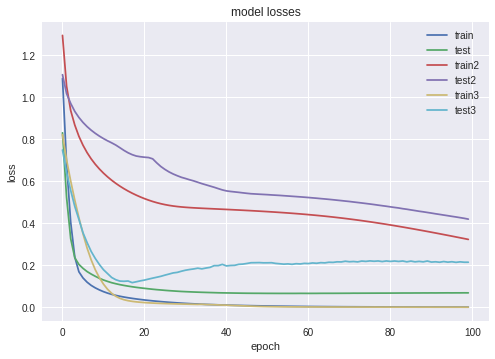

In [984]:
#@title Default title text
plt.plot(history['loss'][0:100])
plt.plot(history['val_loss'][0:100])
plt.plot(history2['loss'][0:100])
plt.plot(history2['val_loss'][0:100])
plt.plot(history3['loss'][0:100])
plt.plot(history3['val_loss'][0:100])
plt.title('model losses')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test','train2', 'test2','train3', 'test3'], loc='upper right');



Here we usually see a large(separable) gap in model losses. When the random starting cisoid parameters are not ideal the training set can actually have a higer loss than the test set. This is something  that needs to be fixed. Of all the times I have ran the code though I have not seen an instance where the test accuracy is consistantly higher than the train accuracy. It may be higher on the first eopch. 

Here we see the large(separable) gap in model losses. 

In [985]:
#@title Data Statistics

# Model 1 
predictions = autoencoder.predict(x_test2,batch_size=32)
mse = np.mean(np.power(x_test2 - predictions, 2), axis=1)
#acc = K.categorical_accuracy(x_test,predictions)
error_df = pd.DataFrame({'reconstruction_error': mse,
                         'true_class': np.array(y_test)})

display(error_df.describe())

# # Model 2 

# predictions2 = autoencoder2.predict(x_test2,batch_size=32)
# mse2 = np.mean(np.power(x_test2 - predictions2, 2), axis=1)
# error_df2 = pd.DataFrame({'reconstruction_error': mse2,
#                          'true_class': np.array(y_test)})

# error_df2.describe()

,reconstruction_error,true_class
count,602.000000,602.000000
mean,0.061898,0.511628
std,0.074983,0.500280
min,0.000190,0.000000
25%,0.000195,0.000000
50%,0.000361,1.000000
75%,0.152940,1.000000
max,0.153142,1.000000


**Reconstruction error without Anomaly**

In [986]:
import tensorflow as tf
from tensorflow.python.keras import backend as K


acc = keras.metrics.categorical_accuracy(x_test2,predictions)
sess = K.get_session()
array = sess.run(acc)

test_accuracy = np.logical_xor(array,np.array(y_test))
np.sum(test_accuracy)



537

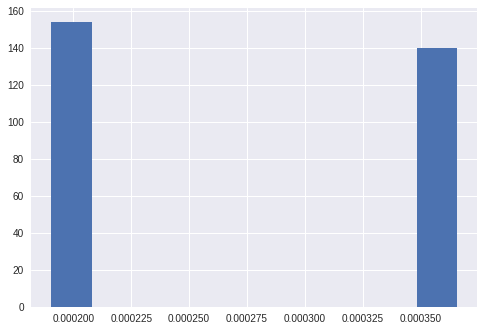

In [987]:
fig = plt.figure()
ax = fig.add_subplot(111)
normal_error_df = error_df[(error_df['true_class']== 0) & (error_df['reconstruction_error'] < 10)]
_ = ax.hist(normal_error_df.reconstruction_error.values, bins=10)

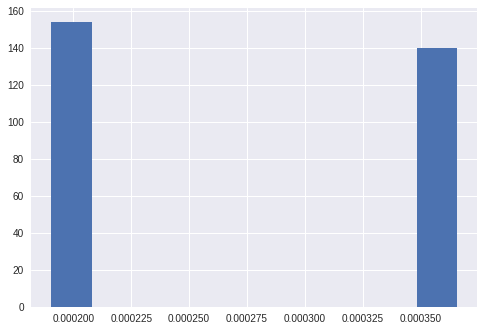

In [988]:
fig = plt.figure()
ax = fig.add_subplot(111)
tmp = removeOutliers(normal_error_df.reconstruction_error.values,1)
n, bins, patches = ax.hist(tmp, bins=10)

**Reconstruction error with Anomaly**

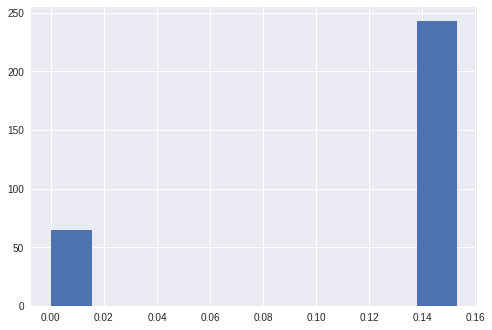

In [989]:
fig = plt.figure()
ax = fig.add_subplot(111)
anomaly_error_df = error_df[error_df['true_class'] == 1]
_ = ax.hist(anomaly_error_df.reconstruction_error.values, bins=10)

In [0]:
threshold1 = (np.median(normal_error_df['reconstruction_error']) + np.median(anomaly_error_df['reconstruction_error']))/2

In [0]:
#threshold1 = np.median(np.hstack((normal_error_df['reconstruction_error'] , anomaly_error_df['reconstruction_error'])))

In [992]:
threshold1.shape

()

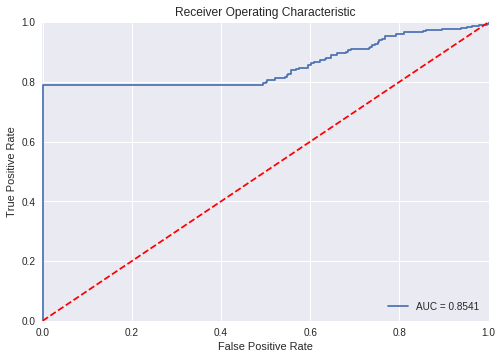

In [993]:
from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc,
                             roc_curve, recall_score, classification_report, f1_score,
                             precision_recall_fscore_support)

fpr, tpr, thresholds = roc_curve(error_df.true_class, error_df.reconstruction_error)
roc_auc = auc(fpr, tpr)

#fpr2, tpr2, thresholds2 = roc_curve(error_df2.true_class, error_df2.reconstruction_error)
#roc_auc2 = auc(fpr2, tpr2)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, label='AUC = %0.4f'% roc_auc)
#plt.plot(fpr2, tpr2, 'go',label='AUC 2 = %0.4f'% roc_auc2)

plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.001, 1])
plt.ylim([0, 1.001])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show();


# **Precision vs Recall**

Ideally one would have a system with both precision and recall equal to one. This would result in a unity plot. We want to maximize the area under the graph given that the range of values is 0 to 1. 

**Model 1**

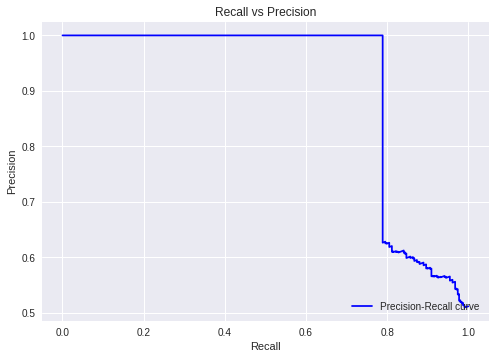

In [994]:
#@title Default title text
precision, recall, th = precision_recall_curve(error_df.true_class, error_df.reconstruction_error)
plt.plot(recall, precision, 'b', label='Precision-Recall curve')
#precision2, recall2, th2 = precision_recall_curve(error_df2.true_class, error_df2.reconstruction_error)
#plt.plot(recall2, precision2, 'r--', label='Precision-Recall curve 2')
plt.title('Recall vs Precision')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc='lower right')
plt.show()

high precision ~ low false positives \\
high recall ~ low false negatives 

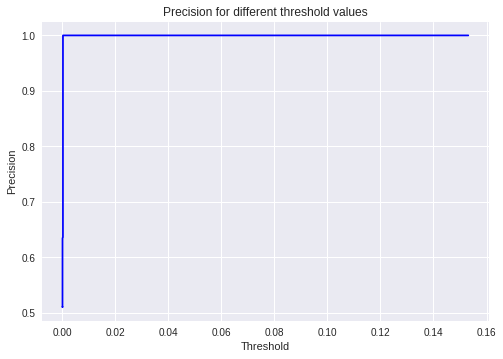

In [995]:
plt.plot(th, precision[1:], 'b', label='Threshold-Precision curve')
plt.title('Precision for different threshold values')
plt.xlabel('Threshold')
plt.ylabel('Precision')
plt.show()

This run of the code shows near ideal retults. Here precision is not a function of reconstruction error.



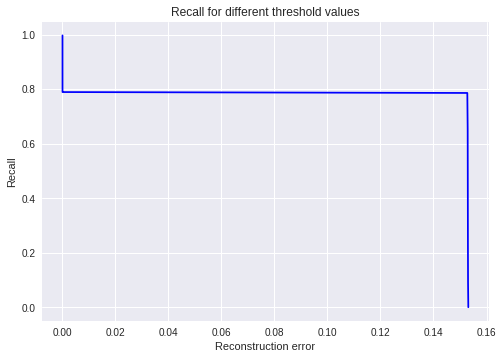

In [996]:
plt.plot(th, recall[1:], 'b', label='Threshold-Recall curve')
plt.title('Recall for different threshold values')
plt.xlabel('Reconstruction error')
plt.ylabel('Recall')
plt.show()

Here we see that as reconstruction error increases recall decreases. 





**Model 2**

In [997]:
predictions2 = autoencoder2.predict(x_test2,batch_size=32)
mse = np.mean(np.power(x_test2 - predictions2, 2), axis=1)
error_df2 = pd.DataFrame({'reconstruction_error': mse,
                         'true_class': np.array(y_test)})

error_df2.describe()

,reconstruction_error,true_class
count,602.000000,602.000000
mean,0.395144,0.511628
std,0.090651,0.500280
min,0.319183,0.000000
25%,0.321461,0.000000
50%,0.321526,1.000000
75%,0.505203,1.000000
max,0.505575,1.000000


In [998]:
acc = keras.metrics.categorical_accuracy(x_test2,predictions2)
sess = K.get_session()
array = sess.run(acc)

test_accuracy = np.logical_xor(array,np.array(y_test))
np.sum(test_accuracy)

537

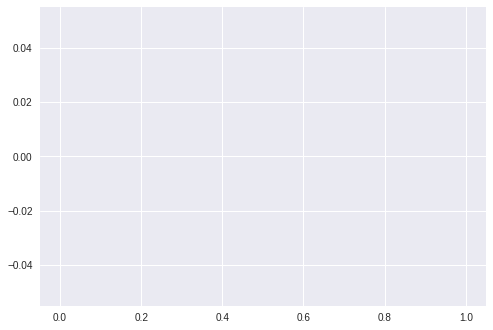

In [999]:
fig = plt.figure()
ax = fig.add_subplot(111)
normal_error_df2 = error_df2[(error_df2['true_class']== 0) & (error_df2['reconstruction_error'] < 0.25)]
_ = ax.hist(normal_error_df2.reconstruction_error.values, bins=10)

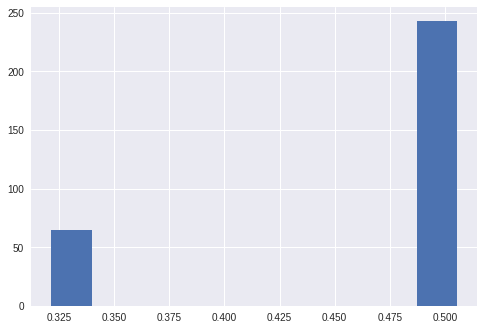

In [1000]:
fig = plt.figure()
ax = fig.add_subplot(111)
anomaly_error_df2 = error_df2[error_df2['true_class'] == 1]
_ = ax.hist(anomaly_error_df2.reconstruction_error.values, bins=10)

In [0]:
threshold2 = (np.max(normal_error_df2)['reconstruction_error'] + np.min(anomaly_error_df2['reconstruction_error']))/2

In [0]:
threshold2 = np.median(np.hstack((normal_error_df2['reconstruction_error'] , anomaly_error_df2['reconstruction_error'])))

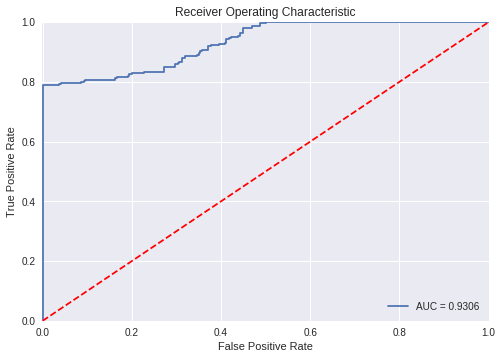

In [1003]:
from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc,
                             roc_curve, recall_score, classification_report, f1_score,
                             precision_recall_fscore_support)

fpr2, tpr2, thresholds = roc_curve(error_df2.true_class, error_df2.reconstruction_error)
roc_auc2 = auc(fpr2, tpr2)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr2, tpr2, label='AUC = %0.4f'% roc_auc2)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.001, 1])
plt.ylim([0, 1.001])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show();

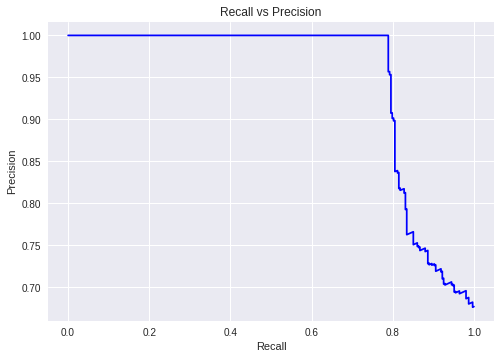

In [1004]:
precision2, recall2, th2 = precision_recall_curve(error_df2.true_class, error_df2.reconstruction_error)
plt.plot(recall2, precision2, 'b', label='Precision-Recall curve')
plt.title('Recall vs Precision')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()



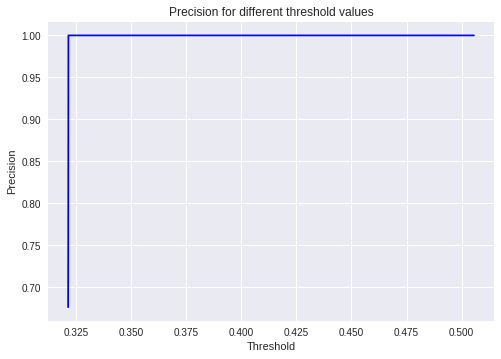

In [1005]:
plt.plot(th2, precision2[1:], 'b', label='Threshold-Precision curve')
plt.title('Precision for different threshold values')
plt.xlabel('Threshold')
plt.ylabel('Precision')
plt.show()



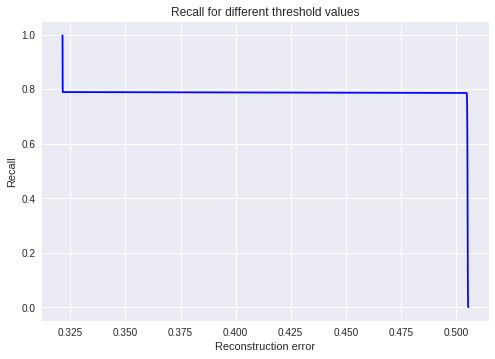

In [1006]:
plt.plot(th2, recall2[1:], 'b', label='Threshold-Recall curve')
#plt.plot(th, recall[1:], 'r.', label='Threshold-Recall curve')
plt.title('Recall for different threshold values')
plt.xlabel('Reconstruction error')
plt.ylabel('Recall')
plt.show()

As in model 1 we see that as reconstruction error increases recall decreases. But it occurs at a much higher value here.

In [1007]:
#@title Data Statistics

# Model 1 
predictions3 = autoencoder3.predict(x_test2,batch_size=32)
mse3 = np.mean(np.power(x_test2 - predictions3, 2), axis=1)
#acc = K.categorical_accuracy(x_test,predictions)
error_df3 = pd.DataFrame({'reconstruction_error': mse3,
                         'true_class': np.array(y_test)})

display(error_df3.describe())

# # Model 2 

# predictions2 = autoencoder2.predict(x_test2,batch_size=32)
# mse2 = np.mean(np.power(x_test2 - predictions2, 2), axis=1)
# error_df2 = pd.DataFrame({'reconstruction_error': mse2,
#                          'true_class': np.array(y_test)})

# error_df2.describe()

,reconstruction_error,true_class
count,602.000000,602.000000
mean,0.209597,0.511628
std,0.254946,0.500280
min,0.000015,0.000000
25%,0.000022,0.000000
50%,0.000023,1.000000
75%,0.519151,1.000000
max,0.519929,1.000000


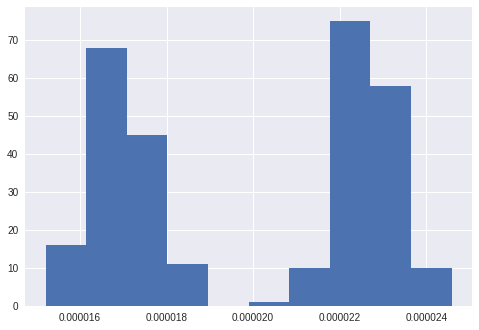

In [1008]:
fig = plt.figure()
ax = fig.add_subplot(111)
normal_error_df3 = error_df3[(error_df3['true_class']== 0) & (error_df3['reconstruction_error'] < 0.25)]
_ = ax.hist(normal_error_df3.reconstruction_error.values, bins=10)

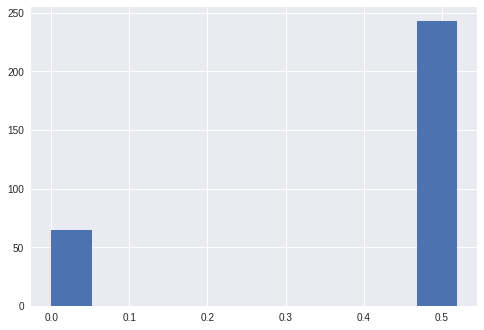

In [1009]:
fig = plt.figure()
ax = fig.add_subplot(111)
anomaly_error_df3 = error_df3[error_df3['true_class'] == 1]
_ = ax.hist(anomaly_error_df3.reconstruction_error.values, bins=10)

In [0]:
threshold3 = np.median(np.hstack((normal_error_df3['reconstruction_error'] , anomaly_error_df3['reconstruction_error'])))

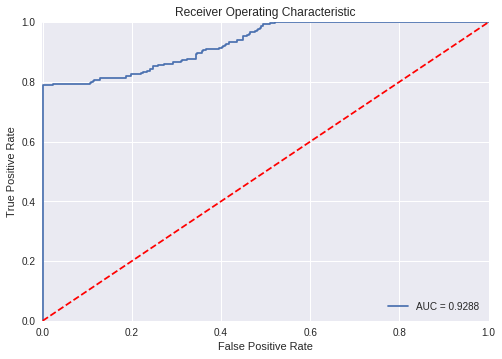

In [1011]:
from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc,
                             roc_curve, recall_score, classification_report, f1_score,
                             precision_recall_fscore_support)

fpr3, tpr3, thresholds = roc_curve(error_df3.true_class, error_df3.reconstruction_error)
roc_auc3 = auc(fpr3, tpr3)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr3, tpr3, label='AUC = %0.4f'% roc_auc3)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.001, 1])
plt.ylim([0, 1.001])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show();

# **Prediction**

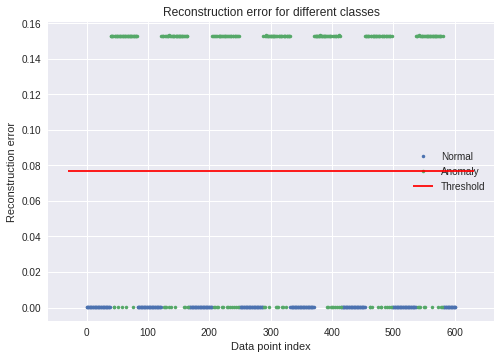

In [1012]:
threshold = threshold1

groups = error_df.groupby('true_class')
fig, ax = plt.subplots()

for name, group in groups:
    ax.plot(group.index, group.reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Anomaly" if name == 1 else "Normal")
ax.hlines(threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show();

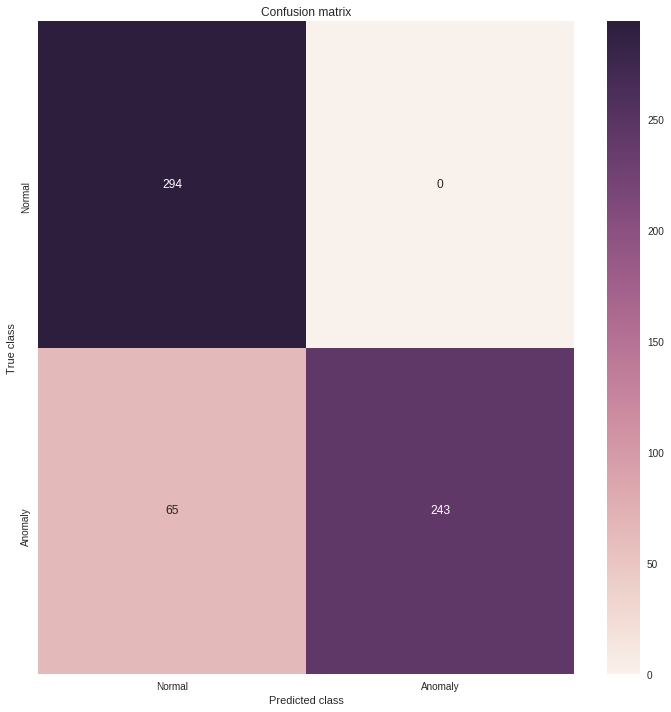

In [1013]:
LABELS = ["Normal", "Anomaly"]
y_pred = [1 if e > threshold else 0 for e in error_df.reconstruction_error.values]
conf_matrix = confusion_matrix(error_df.true_class, y_pred)

plt.figure(figsize=(12, 12))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()



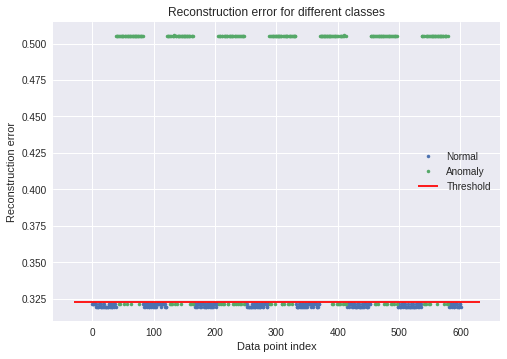

In [1032]:
threshold = .323

groups = error_df2.groupby('true_class')
fig, ax = plt.subplots()

for name, group in groups:
    ax.plot(group.index, group.reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Anomaly" if name == 1 else "Normal")
ax.hlines(threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show();

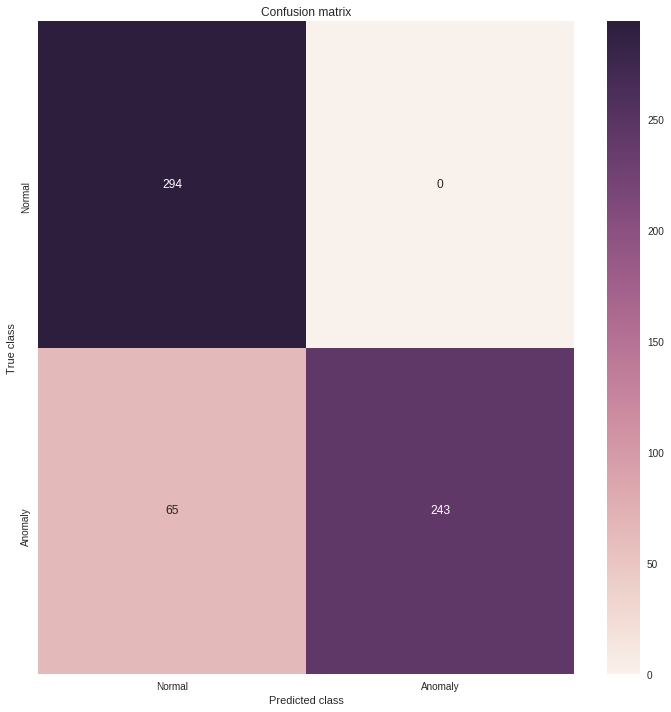

In [1033]:
LABELS = ["Normal", "Anomaly"]
y_pred = [1 if e > threshold else 0 for e in error_df2.reconstruction_error.values]
conf_matrix = confusion_matrix(error_df2.true_class, y_pred)

plt.figure(figsize=(12, 12))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()



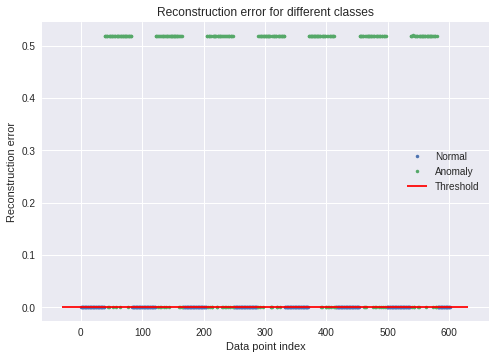

In [1016]:
threshold = threshold3

groups = error_df3.groupby('true_class')
fig, ax = plt.subplots()

for name, group in groups:
    ax.plot(group.index, group.reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Anomaly" if name == 1 else "Normal")
ax.hlines(threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show();

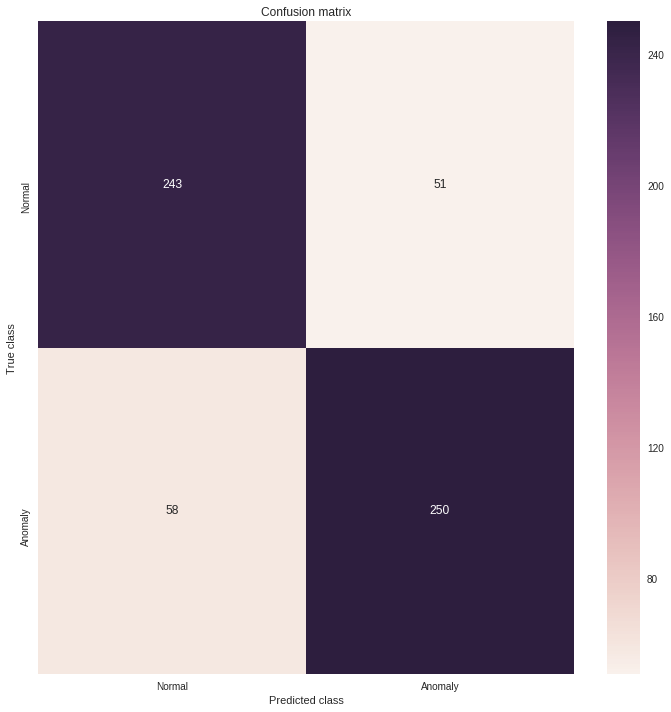

In [1017]:
LABELS = ["Normal", "Anomaly"]
y_pred = [1 if e > threshold else 0 for e in error_df3.reconstruction_error.values]
conf_matrix = confusion_matrix(error_df3.true_class, y_pred)

plt.figure(figsize=(12, 12))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()



In [1018]:
#@title Model 1 - Elu { form-width: "20%" }
from keras import regularizers
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
# Make sure to run this after each new generation of data

#1
# zero mean and unit var
# this makes train and test data zero mean and unit var individually 
# we should statistics of ideal data(no anomaly) 
# hense we should standadize both sets of data based on this
#x_train2 = StandardScaler().fit_transform(x_train)
#x_test2 = StandardScaler().fit_transform(x_test)

#2
# zero mean and unit var 
# x_trainScaled = preprocessing.scale(x_train)
# scaler = StandardScaler().fit(x_trainScaled)
# x_train2 = scaler.transform(x_trainScaled)
# x_test2 = scaler.transform(x_test)

m1 = np.mean(x_train)
s1 = np.std(x_train)

x_train2 = (x_train-m1)/s1
x_test2 = (x_test-m1)/s1
#3
#x_train2 = x_train
#x_test2 = x_test

#4
#zero mean and unit var 
# scaler = StandardScaler().fit(x_test)
# x_train2 = scaler.transform(x_train)
# x_test2 = scaler.transform(x_test)

#x_train2 = x_train2[:,:,np.newaxis]
#x_test2 = x_test2[:,:,np.newaxis]

#x_train2 = x_train2.astype('float32') / 255.
#x_test2 = x_test2.astype('float32') / 255.

display(x_train2.shape)

input_dim = x_train.shape[1]

# set size of autoencoder 
encoding_dim = 6

# use elu because it is leaky tried both net and l1 and l2 : net and l1 worked the best 
input_layer = Input(shape=(input_dim, ))
encoder = Dense(encoding_dim, activation="elu",kernel_initializer= 'he_normal',
                activity_regularizer=regularizers.l1_l2(l1=10e-5, l2=75.10e-5))(input_layer)
#encoder = Dense(encoding_dim, activation="elu",activity_regularizer=regularizers.l1(10e-5))(input_layer)
encoder = Dense(int(encoding_dim / 2), activation="elu",kernel_initializer= 'he_normal')(encoder)
decoder = Dense(int(encoding_dim / 2), activation='elu',kernel_initializer= 'he_normal')(encoder)
decoder = Dense(input_dim, activation='elu',kernel_initializer= 'he_normal')(decoder)
autoencoder = Model(inputs=input_layer, outputs=decoder)

autoencoder.summary()  


(602, 6)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_146 (InputLayer)       (None, 6)                 0         
_________________________________________________________________
dense_178 (Dense)            (None, 6)                 42        
_________________________________________________________________
dense_179 (Dense)            (None, 3)                 21        
_________________________________________________________________
dense_180 (Dense)            (None, 3)                 12        
_________________________________________________________________
dense_181 (Dense)            (None, 6)                 24        
Total params: 99
Trainable params: 99
Non-trainable params: 0
_________________________________________________________________


In [1019]:
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D,Conv1D,MaxPooling1D
from keras.models import Model
from keras import backend as K

m1 = np.mean(x_train)
s1 = np.std(x_train)

x_train2 = (x_train-m1)/s1
x_test2 = (x_test-m1)/s1

x_train2 = x_train2[:,:,np.newaxis]
x_test2 = x_test2[:,:,np.newaxis]

input_dim = x_train.shape[1]

# set size of autoencoder 
encoding_dim = 6

# use elu because it is leaky tried both net and l1 and l2 : net and l1 worked the best 
input_layer = Input(shape=(input_dim,1))
x = Conv1D(16,  kernel_size=(3), activation='elu', padding='same',kernel_initializer= 'he_normal',
          activity_regularizer=regularizers.l1_l2(l1=10e-5, l2=75.10e-5))(input_layer)
x = MaxPooling1D(pool_size=2, strides=None, padding='same')(x)
x = Conv1D(8,  3, activation='elu', padding='same',kernel_initializer= 'he_normal')(x)
x = MaxPooling1D(pool_size=2, strides=None, padding='same')(x)
x = Conv1D(8,  3, activation='elu', padding='same',kernel_initializer= 'he_normal')(x)
encoded = MaxPooling1D( 2, padding='same')(x)

# # at this point the representation is (4, 4, 8) i.e. 128-dimensional

x = Conv1D(8, 3, activation='elu', padding='same',kernel_initializer= 'he_normal')(encoded)
x = UpSampling1D( 2)(x)
x = Conv1D(8, 3, activation='elu', padding='same',kernel_initializer= 'he_normal')(x)
x = UpSampling1D( 2)(x)
x = Conv1D(16, 3, activation='elu',kernel_initializer= 'he_normal')(x)
x = UpSampling1D( 3)(x)
x = Conv1D(1,  3, activation='elu', padding='same',kernel_initializer= 'he_normal')(x)
decoded = Dense(input_dim, activation='softmax',kernel_initializer= 'he_normal')(decoder)

autoencoder4 = Model(input_layer, x)
autoencoder4.summary()  


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_147 (InputLayer)       (None, 6, 1)              0         
_________________________________________________________________
conv1d_372 (Conv1D)          (None, 6, 16)             64        
_________________________________________________________________
max_pooling1d_173 (MaxPoolin (None, 3, 16)             0         
_________________________________________________________________
conv1d_373 (Conv1D)          (None, 3, 8)              392       
_________________________________________________________________
max_pooling1d_174 (MaxPoolin (None, 2, 8)              0         
_________________________________________________________________
conv1d_374 (Conv1D)          (None, 2, 8)              200       
_________________________________________________________________
max_pooling1d_175 (MaxPoolin (None, 1, 8)              0         
__________

In [1020]:
#@title Model 3 - Elu Maxout: Train/Test

#Results with 40 sample of anomily every 40 samples
full_anom = 0
anom_samples = 40
nb_epoch = 100 # a bit overkill but wanted to see how it progressed w more epochs 
batch_size = 32
import keras
autoencoder4.compile(optimizer='nadam', 
                    loss='mean_squared_error' 
                    #loss='kullback_leibler_divergence',
                    )
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.2,min_lr=1e-6,min_delta=0.0001,
                              patience=37,verbose = 1)

checkpointer = ModelCheckpoint(filepath="model2.h5",
                               verbose=0,
                               save_best_only=True)
tensorboard = TensorBoard(log_dir='./logs',
                          histogram_freq=0,
                          write_graph=True,
                          write_images=True)
history4 = autoencoder4.fit(x_train2, x_train2,
                    epochs=nb_epoch,
                    batch_size=batch_size,
                    validation_data=(x_test2, x_test2),
                    validation_split=.1,
                    shuffle=True,
                    verbose=1,callbacks=[reduce_lr, checkpointer, tensorboard]).history 

score4 = autoencoder4.evaluate(x_test2, x_test2, batch_size=batch_size, verbose=1, sample_weight=None, steps=None)

display('[test_loss]')
display(score2)

Train on 602 samples, validate on 602 samples
Epoch 1/100
602/602 [==============================] - 3s 4ms/step - loss: 2.7124 - val_loss: 2.2056
Epoch 2/100
602/602 [==============================] - 0s 774us/step - loss: 2.0605 - val_loss: 1.9285
Epoch 3/100
602/602 [==============================] - 0s 781us/step - loss: 1.7976 - val_loss: 1.7270
Epoch 4/100
602/602 [==============================] - 0s 770us/step - loss: 1.6061 - val_loss: 1.5606
Epoch 5/100
602/602 [==============================] - 0s 792us/step - loss: 1.4481 - val_loss: 1.4091
Epoch 6/100
602/602 [==============================] - 0s 768us/step - loss: 1.3047 - val_loss: 1.2846
Epoch 7/100
602/602 [==============================] - 0s 768us/step - loss: 1.1889 - val_loss: 1.1741
Epoch 8/100
602/602 [==============================] - 0s 758us/step - loss: 1.0794 - val_loss: 1.0769
Epoch 9/100
602/602 [==============================] - 0s 774us/step - loss: 0.9848 - val_loss: 0.9901
Epoch 10/100
602/602 [=======

'[test_loss]'

0.21495402678290376

In [1021]:
predictions4.squeeze().shape

(602, 6)

In [1022]:

# Model 1 
predictions4 = autoencoder4.predict(x_test2,batch_size=32)

mse4 = np.mean(np.power(x_test2.squeeze() - predictions4.squeeze(), 2), axis=1)
#acc = K.categorical_accuracy(x_test,predictions)
error_df4 = pd.DataFrame({'reconstruction_error': mse4,
                         'true_class': np.array(y_test)})

display(error_df4.describe())

# # Model 2 

# predictions2 = autoencoder2.predict(x_test2,batch_size=32)
# mse2 = np.mean(np.power(x_test2 - predictions2, 2), axis=1)
# error_df2 = pd.DataFrame({'reconstruction_error': mse2,
#                          'true_class': np.array(y_test)})

# error_df2.describe()


,reconstruction_error,true_class
count,602.000000,602.000000
mean,0.065620,0.511628
std,0.078962,0.500280
min,0.000191,0.000000
25%,0.001037,0.000000
50%,0.001040,1.000000
75%,0.161493,1.000000
max,0.161712,1.000000


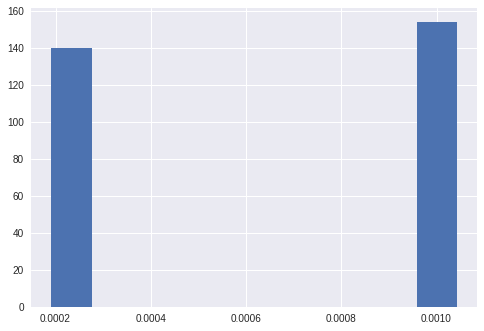

In [1023]:
fig = plt.figure()
ax = fig.add_subplot(111)
normal_error_df4 = error_df4[(error_df4['true_class']== 0) & (error_df4['reconstruction_error'] < 10)]
_ = ax.hist(normal_error_df4.reconstruction_error.values, bins=10)


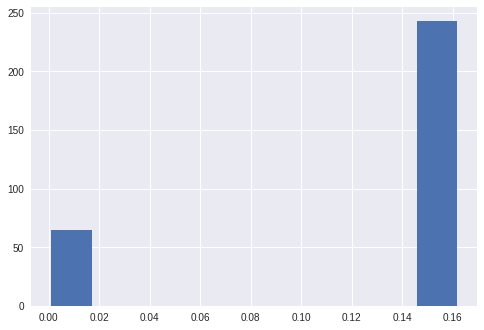

In [1024]:
fig = plt.figure()
ax = fig.add_subplot(111)
anomaly_error_df4 = error_df4[error_df4['true_class'] == 1]
_ = ax.hist(anomaly_error_df4.reconstruction_error.values, bins=10)
threshold4 = np.median(np.hstack((normal_error_df4['reconstruction_error'] , anomaly_error_df4['reconstruction_error'])))


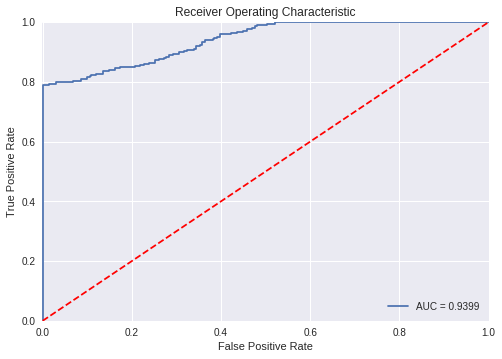

In [1025]:
from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc,
                             roc_curve, recall_score, classification_report, f1_score,
                             precision_recall_fscore_support)

fpr4, tpr4, thresholds = roc_curve(error_df4.true_class, error_df4.reconstruction_error)
roc_auc4 = auc(fpr4, tpr4)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr4, tpr4, label='AUC = %0.4f'% roc_auc4)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.001, 1])
plt.ylim([0, 1.001])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show();

In [1026]:
threshold4

0.0010398110216724883

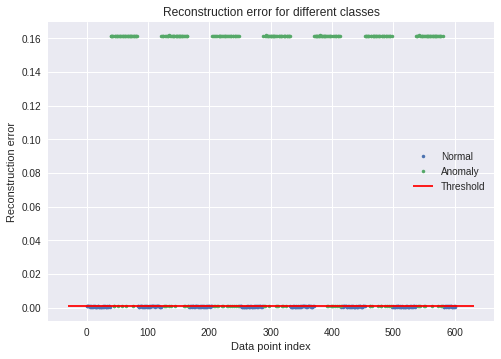

In [1027]:
threshold = threshold4

groups = error_df4.groupby('true_class')
fig, ax = plt.subplots()

for name, group in groups:
    ax.plot(group.index, group.reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Anomaly" if name == 1 else "Normal")
ax.hlines(threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show();

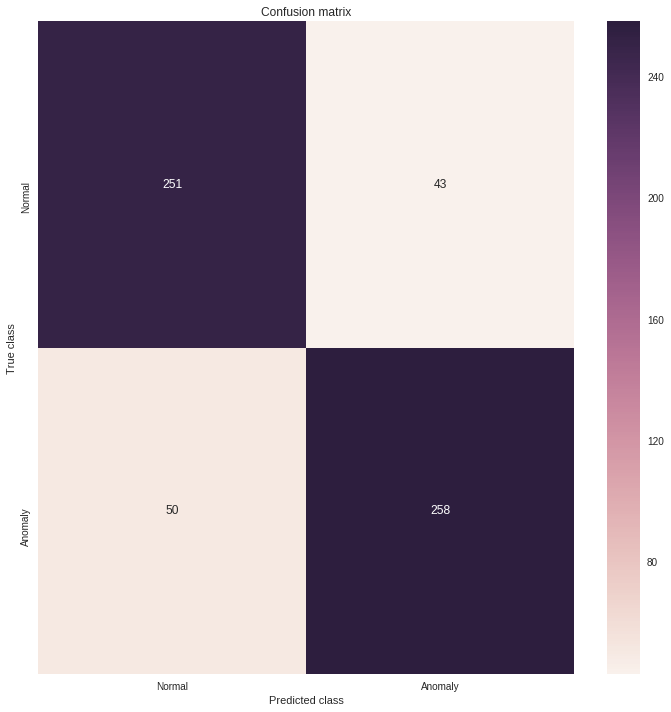

In [1028]:
LABELS = ["Normal", "Anomaly"]
y_pred = [1 if e > threshold else 0 for e in error_df4.reconstruction_error.values]
conf_matrix = confusion_matrix(error_df4.true_class, y_pred)

plt.figure(figsize=(12, 12))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

